<a href="https://colab.research.google.com/github/VT-HaTrang/Data-Mining-Bank-credit-risk-prediction/blob/main/Preprocessing_and_Prediction_using_DP_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ĐỒ ÁN KTDL/Project

/content/drive/MyDrive/ĐỒ ÁN KTDL/Project


In [ ]:
%pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# For reading our dataset
import pandas as pd

import numpy as np

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

# For warnings
import warnings
warnings.filterwarnings(action='ignore')

# Importing necessary packages for building and tuning our model
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from imblearn.under_sampling import NearMiss               # For Undersampling
from imblearn.over_sampling import RandomOverSampler       # For Oversampling
from imblearn.combine import SMOTETomek                    # For Both Undersampling & Oversampling
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras_tuner.tuners import RandomSearch
import random
import logging
import datetime

# For checking acuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# CHUẨN BỊ VÀ TIỀN XỬ LÝ DỮ LIỆU

### Import Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IS252. Data Mining/ĐỒ ÁN KTDL/data_bank_b.csv')
df.head()

KeyboardInterrupt: ignored

In [ ]:
df.sample(5)

In [ ]:
df.shape

### Target Variable

In [ ]:
df['loan_status'].value_counts(dropna=False)

Chúng tôi sẽ tìm hiểu sự khác biệt trong các tính năng giữa các khoản vay đã hoàn thành và thanh toán đầy đủ (Fully Paid) hoặc bị mất trắng (Charged Off). Chúng tôi sẽ không xem xét các khoản vay chưa kết thúc (current, Late, In grace Period, Default). Vì vậy, chúng tôi chỉ giữ các khoản vay có trạng thái "Fully Paid" hoặc "Charged off".

In [ ]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]
df.shape

In [ ]:
df['loan_status'].value_counts(dropna=False)

In [ ]:
df['loan_status'].value_counts(normalize=True, dropna=False)

### Data Cleaning

In [ ]:
#Tìm trong dữ liệu có giá trị Null hay không
total = df.isnull().sum().sort_values(ascending=False) #Tim trong du lieu gia tri null, tinh tong chung lai, sap xep theo tang dan
percent_1=df.isnull().sum()/df.isnull().count()*100 #Tong gia tri null cua mot cot/ so dong cua cot null do
percent_2=(round(percent_1,1)).sort_values(ascending=False) #Lam trong 1 chu so va giam dan
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head()

In [ ]:
print('Number of Columns with under 15% missing values:', 
      missing_data[missing_data['%']<=15].shape[0])

#Vẽ sơ đồ phân phối các phần của các giá trị bị thiếu cho các cột
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(missing_data['%'], bins=20, kde=False, rug=True)
ax.set_title('Distribution of Percent of Missing Values')
ax.set_xlabel('%')
ax.set_ylabel('Count')
sns.despine()

Từ biểu đồ trên, chúng tôi thấy có một khoảng cách lớn giữa các thuộc tính thiếu "một số" dữ liệu (<20%) và những thuộc tính thiếu "rất nhiều" dữ liệu (>40%). Bởi vì nhìn chung rất khó để tính toán chính xác dữ liệu với hơn 40% giá trị bị thiếu, nên chúng tôi bỏ các cột như vậy.

In [ ]:
# Lấy danh sách các cột có tỷ lệ giá trị thiếu lớn hơn 40%
cols_to_drop = list(missing_data[missing_data['%']>=40].index)

# Xóa các cột đó khỏi dataframe
df = df.drop(cols_to_drop, axis=1)
df.shape

### Selected Feature

Chỉ giữ các tính năng cho vay được các nhà đầu tư tiềm năng biết đến, chúng tôi đã kiểm tra ý nghĩa mỗi tính năng và tham khảo tài liệu để xác định những tính năng nào sẽ có sẵn cho các nhà đầu tư tiềm năng.

In [ ]:
print(sorted(df.columns))

In [ ]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 
             'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 
             'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 
             'issue_d', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 
             'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 
             'term', 'title', 'total_acc', 'verification_status', 'zip_code']

In [ ]:
len(keep_list)

In [ ]:
drop_list = [col for col in df.columns if col not in keep_list]
print(drop_list)

In [ ]:
len(drop_list)

In [ ]:
df.drop(drop_list, axis=1, inplace=True)
df.shape

### Pre-processing and Exploratory

Chúng tôi sẽ kiểm tra từng tính năng riêng lẻ và thực hiện như sau:
   * Bỏ tính năng này nếu nó không hữu ích để dự đoán tình trạng khoản vay (loan_status).
   * Xem thống kê tóm tắt và trực quan hóa dữ liệu, vẽ sơ đồ dựa trên trạng thái khoản vay.
   * Sửa đổi tính năng để làm cho nó hữu ích cho việc lập mô hình, nếu cần.

Chúng tôi tạo một hàm để vẽ biểu đồ cho một biến và so sánh với biến loan_status:

In [ ]:
def plot_var(col_name, full_name, continuous):
    """
    Trực quan hóa một biến có và không có khía cạnh về loan_status.
    - col_name là tên biến trong dataframe
    - full_name là tên biến đầy đủ
    - countinuous là True nếu biến là liên tục, False nếu ngược lại
    """
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
    
    # Plot without loan_status
    if continuous:
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(data = df, x =col_name, order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count') 
    ax1.set_title(full_name)

    # Plot with loan status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        charge_off_rates = df.groupby(col_name)['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']
        sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged-off')
        ax2.set_title('Charge-off Rate by ' + full_name)
    ax2.set_xlabel(full_name)
    plt.tight_layout()

In [ ]:
print(list(df.columns))

#### id

In [ ]:
df['id'].sample(5)

In [ ]:
df['id'].describe()

Nhận thấy tất cả chúng đều unique. ID không hữu ích cho việc lập mô hình, dưới dạng biến phân loại (có quá nhiều giá trị riêng biệt) hoặc dưới dạng biến số (ID thay đổi rất nhiều về độ lớn, có thể không có bất kỳ ý nghĩa nào), vì vậy chúng tôi loại bỏ biến này.

In [ ]:
df.drop('id', axis=1, inplace=True)

#### loan_amnt

Mô tả: "Số tiền được liệt kê của khoản vay mà người vay đăng ký. Nếu tại một thời điểm nào đó, bộ phận tín dụng giảm số tiền cho vay, thì nó sẽ được phản ánh trong giá trị này."

In [ ]:
df['loan_amnt'].describe()

Số tiền cho vay dao động từ 500 đô la đến 40.000 đô la, với mức trung bình là 12.000 đô la.

In [ ]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

Các khoản vay charged-off có xu hướng có số tiền cho vay cao hơn. Cùng so sánh thống kê tóm tắt theo loan_status:

In [ ]:
df.groupby('loan_status')['loan_amnt'].describe()

#### term

Mô tả: "Kỳ hạn thanh toán khoản vay. Giá trị tính theo tháng và có thể là 36 tháng hoặc 60 tháng."

In [ ]:
df['term'].value_counts(dropna=False)

In [ ]:
#Đổi thành kiểu integers
df['term'] = df['term'].apply(lambda s: np.int8(s.split()[0]))
df['term'].value_counts(normalize=True)

In [ ]:
df['term'].value_counts(dropna=False)

So sánh lãi suất charged-off theo thời hạn vay:

In [ ]:
df.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

Hơn 76% các khoản vay đã hoàn thành có kỳ hạn 3 năm và phần còn lại có kỳ hạn 5 năm. Các khoản vay có thời hạn 5 năm có khả năng bị charged-off cao hơn gấp đôi so với các khoản vay có thời hạn 3 năm.

#### int_rate

Mô tả: "Lãi suất cho vay."

In [ ]:
df['int_rate'].describe()

Lãi suất dao động từ 5,32% đến 30,99% (!) với mức trung bình là 13,1%.

In [ ]:
plot_var('int_rate', 'Interest Rate', continuous=True)

Các khoản vay charged-off có xu hướng có lãi suất cao hơn nhiều. Cùng so sánh thống kê tóm tắt theo tình trạng khoản vay:

In [ ]:
df.groupby('loan_status')['int_rate'].describe()

#### Installment

Mô tả: "Khoản thanh toán hàng tháng của người vay."

In [ ]:
df['installment'].describe()

Các khoản trả góp dao động từ $4,93 đến $1,714, với trung bình là $377.

In [ ]:
plot_var('installment', 'Installment', continuous=True)

Các khoản vay charged-off có xu hướng trả góp cao hơn. Cùng so sánh thống kê tóm tắt theo loan_status:

In [ ]:
df.groupby('loan_status')['installment'].describe()

Các khoản vay charged-off có số tiền trả góp trung bình cao hơn $30.

#### grade, sub_grade

Mô tả grade: "LendingClub chỉ định cấp cho vay."

Mô tả cho sub_grade: "LendingClub chỉ định cấp dưới cho khoản vay."

Các giá trị có thể có của grade và sub_grade là gì?

In [ ]:
print(sorted(df['grade'].unique()))

In [ ]:
print(sorted(df['sub_grade'].unique()))

Grade được ngụ ý bởi sub_grade, vì vậy ta bỏ cột Grade.

In [ ]:
df.drop('grade', axis=1, inplace=True)

In [ ]:
plot_var('sub_grade', 'Subgrade', continuous=False)

Có một xu hướng rõ ràng là xác suất charged-off cao hơn khi sub_grade xấu đi.

#### emp_title

Mô tả: "Chức vụ do Bên vay cung cấp khi đăng ký khoản vay."

In [ ]:
df['emp_title'].describe()

Có quá nhiều chức danh công việc khác nhau để tính năng này trở nên hữu ích, vì vậy chúng tôi bỏ nó.

In [ ]:
df.drop(labels='emp_title', axis=1, inplace=True)

#### emp_length

Mô tả: "Thời gian làm việc tính bằng năm. Các giá trị có thể nằm trong khoảng từ 0 đến 10 trong đó 0 có nghĩa là dưới một năm và 10 có nghĩa là mười năm trở lên." Dữ liệu thực tế không khớp với mô tả này:

In [ ]:
df['emp_length'].value_counts(dropna=False).sort_index()

Lưu ý rằng có 38559 khoản vay không có dữ liệu về thời gian làm việc.

Chuyển đổi emp_length thành số nguyên:

In [ ]:
df['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

In [ ]:
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [ ]:
def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])

In [ ]:
df['emp_length'] = df['emp_length'].apply(emp_length_to_int)

In [ ]:
df['emp_length'].value_counts(dropna=False).sort_index()

In [ ]:
plot_var('emp_length', 'Employment Length', continuous=False)

Tình trạng khoản vay dường như không thay đổi nhiều theo thời gian làm việc trung bình, ngoại trừ một sự sụt giảm nhỏ trong các khoản charged-off đối với những người vay có hơn 10 năm làm việc.

#### home_owenership

Mô tả: "Tình trạng sở hữu nhà do người vay cung cấp trong quá trình đăng ký hoặc thu được từ báo cáo tín dụng. Các giá trị của chúng tôi là: THUÊ, SỞ HỮU, THẾ CHẤP, KHÁC."

In [ ]:
df['home_ownership'].value_counts(dropna=False)

Thay thế các giá trị ANY và NONE bằng OTHER:

In [ ]:
df['home_ownership'].replace(['NONE', 'ANY'], 'OTHER', inplace=True)

In [ ]:
df['home_ownership'].value_counts(dropna=False)

In [ ]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

Dường như có sự khác biệt lớn về tỷ lệ chared-off theo tình trạng sở hữu nhà. Người thuê nhà và chủ nhà có xác suất chared-off cao hơn. Hãy so sánh tỷ lệ chared-off:

In [ ]:
df.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

#### annual_inc

Mô tả: "Thu nhập hàng năm tự báo cáo do người vay cung cấp trong quá trình đăng ký."

In [ ]:
df['annual_inc'].describe()

Thu nhập hàng năm dao động từ $0 đến $10,999,200, với mức median là $74,000. Do phạm vi thu nhập lớn, chúng ta nên thực hiện phép biến đổi log của biến thu nhập hàng năm.

In [ ]:
df['log_annual_inc'] = df['annual_inc'].apply(lambda x: np.log10(x+1))

In [ ]:
df.drop('annual_inc', axis=1, inplace=True)

In [ ]:
df['log_annual_inc'].describe()

In [ ]:
plot_var('log_annual_inc', 'Log Annual Income', continuous=True)

Có vẻ như những cá nhân có thu nhập cao hơn có nhiều khả năng trả hết nợ hơn. So sánh thống kê tóm tắt theo tình trạng khoản vay:

In [ ]:
df.groupby('loan_status')['log_annual_inc'].describe()

#### verification_status

Mô tả: "Cho biết thu nhập đã được xác minh bởi [Lending Club], chưa được xác minh hay nếu nguồn thu nhập đã được xác minh."

In [ ]:
plot_var('verification_status', 'Verification Status', continuous=False)

#### issue_d

Mô tả: "Tháng-Năm mà khoản vay được tài trợ."

Vì chúng tôi chỉ sử dụng các biến có sẵn cho nhà đầu tư trước khi khoản vay được tài trợ, nên issue_d sẽ không được đưa vào mô hình cuối cùng.

In [ ]:
df = df.drop('issue_d', axis=1)

#### purpose

Mô tả: "Một danh mục được cung cấp bởi người vay cho yêu cầu cho vay."

In [ ]:
df['purpose'].value_counts()

Tính tỷ lệ charged-off theo purpose:

In [ ]:
df.groupby('purpose')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

Chỉ có khoảng 16% các khoản vay đã hoàn thành với mục đích cho ô tô bị charged-off, nhưng hơn 31% các khoản vay với mục đích kinh doanh nhỏ đã hoàn thành  bị charged-off.

#### title

Mô tả: "Tiêu đề khoản vay do người vay cung cấp."

In [ ]:
df['title'].describe()

Xem 10 tiêu đề cho vay hàng đầu và tần suất xuất hiện của chúng:

In [ ]:
df['title'].value_counts().head(10)

Có 25 tiêu đề khác nhau trong bộ dữ liệu và dựa trên 10 tiêu đề hàng đầu, biến purpose dường như đã chứa thông tin này. Vì vậy, chúng tôi loại bỏ biến tiêu đề.

In [ ]:
df.drop('title', axis=1, inplace=True)

#### 15. zip_code, addr_state

Mô tả zip_code: "3 số đầu tiên của mã zip được người vay cung cấp trong đơn xin vay."

Mô tả addr_state: "Trạng thái được người vay cung cấp trong đơn xin vay."

In [ ]:
df['zip_code'].sample(5)

In [ ]:
df['zip_code'].nunique()

In [ ]:
df['addr_state'].sample(5)

In [ ]:
df['addr_state'].nunique()

Có rất nhiều mã zip khác nhau, vì vậy chúng ta hãy giữ cột state.

In [ ]:
df.drop(labels='zip_code', axis=1, inplace=True)

Tính tỷ lệ charged-off theo address state:

In [ ]:
df.groupby('addr_state')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off'].sort_values()

Tỷ lệ charge-off dao động từ 13,96% ở VT, DC đến 26% ở AR.

#### 16.dti

Mô tả: "Tỷ lệ được tính bằng cách sử dụng tổng số tiền trả nợ hàng tháng của người vay trên tổng nghĩa vụ nợ, không bao gồm thế chấp và khoản vay LC được yêu cầu, chia cho thu nhập hàng tháng tự báo cáo của người vay."

In [ ]:
df['dti'].describe()

Lưu ý chắc chắn nếu các giá trị của -1 và 999 có ý nghĩa...

Có một số ngoại lệ làm rối các plot mặc định của chúng tôi. Vẽ biểu đồ cho dti nhỏ hơn 60:

In [ ]:
plt.figure(figsize=(8,3), dpi=90)
sns.distplot(df.loc[df['dti'].notnull() & (df['dti']<60), 'dti'], kde=False)
plt.xlabel('Debt-to-income Ratio')
plt.ylabel('Count')
plt.title('Debt-to-income Ratio')

Có bao nhiêu giá trị dti là "ngoại lệ" (trên 60)?

In [ ]:
(df['dti']>=60).sum()

Số lượng ít. So sánh thống kê tóm tắt theo tình trạng loan_status:

In [ ]:
df.groupby('loan_status')['dti'].describe()

Các khoản vay đã hoàn thành bị charged off có xu hướng có tỷ lệ nợ trên thu nhập (debt-to-income) cao hơn.

#### 17.earliest_cr_line

Mô tả: "Tháng hạn mức tín dụng được báo cáo sớm nhất của người đi vay đã được mở."

In [ ]:
df['earliest_cr_line'].head(20)

Giá trị thuộc tính nó không rõ ràng nên chúng tôi sẽ bỏ thuộc tính này.

In [ ]:
df = df.drop('earliest_cr_line', axis=1)

#### 18. fico_range_low, fico_range_high

Mô tả fico_range_low: "Phạm vi ranh giới thấp hơn thuộc về FICO của người đi vay tại thời điểm bắt đầu khoản vay."

Mô tả fico_range_high: "Phạm vi ranh giới trên thuộc về FICO của người vay khi bắt đầu khoản vay."

In [ ]:
df[['fico_range_low', 'fico_range_high']].describe()

In [ ]:
df[['fico_range_low','fico_range_high']].corr()

Chúng tôi chỉ cần giữ một trong các điểm FICO. Chúng tôi sẽ lấy trung bình của cả hai và gọi nó là fico_score:

In [ ]:
df['fico_score'] = 0.5*df['fico_range_low'] + 0.5*df['fico_range_high']

In [ ]:
df.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

In [ ]:
plot_var('fico_score', 'FICO Score', continuous=True)

Có một sự khác biệt đáng chú ý về điểm số FICO giữa các khoản vay fully paid và các khoản vay charged-off. So sánh số liệu thống kê tóm tắt:

In [ ]:
df.groupby('loan_status')['fico_score'].describe()

Các khoản cho vay charge off có điểm FICO trung bình thấp hơn 10 điểm.

#### 19.open_acc

Mô tả: "Số hạn mức tín dụng mở trong hồ sơ tín dụng của người đi vay."

In [ ]:
plt.figure(figsize=(10,3), dpi=90)
sns.countplot(data=df, x='open_acc', order=sorted(df['open_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
plt.title('Number of Open Credit Lines')

Có sự khác biệt về số hạn mức tín dụng giữa các khoản vay fully paid và các khoản vay charged-off không?

In [ ]:
df.groupby('loan_status')['open_acc'].describe()

#### 20. pub_rec

Mô tả: "Số lần ghi nhận công khai về việc vay tiền không trả (nợ xấu)"

In [ ]:
df['pub_rec'].value_counts().sort_index()

Có sự khác biệt trong record công khai trung bình giữa các khoản vay fully paid và các khoản vay bị charged-off không?

In [ ]:
df.groupby('loan_status')['pub_rec'].describe()

#### 21. revol_bal

Mô tả: "Tổng số dư quay vòng tín dụng."

In [ ]:
df['revol_bal'].describe()

Thực hiện chuyển đổi log:

In [ ]:
df['log_revol_bal'] = df['revol_bal'].apply(lambda x: np.log10(x+1))

In [ ]:
df.drop('revol_bal', axis=1, inplace=True)

In [ ]:
plot_var('log_revol_bal', 'Log Revolving Credit Balance', continuous=True)

In [ ]:
df.groupby('loan_status')['log_revol_bal'].describe()

Không có sự khác biệt lớn về mean.

#### 22. revol_util

Mô tả: "Tỷ lệ sử dụng dòng quay vòng hoặc số tiền tín dụng mà người vay đang sử dụng so với tất cả tín dụng quay vòng có sẵn."

In [ ]:
df['revol_util'].describe()

In [ ]:
plot_var('revol_util', 'Revolving Line Utilization', continuous=True)

In [ ]:
df.groupby('loan_status')['revol_util'].describe()

#### 23. total_acc

Mô tả: "Tổng số hạn mức tín dụng hiện có trong hồ sơ tín dụng của người vay."

In [ ]:
plt.figure(figsize=(12,3), dpi=90)
sns.countplot(data=df, x='total_acc', order=sorted(df['total_acc'].unique()), color='#5975A4', saturation=1)
_, _ = plt.xticks(np.arange(0, 176, 10), np.arange(0, 176, 10))
plt.title('Total Number of Credit Lines')

In [ ]:
df.groupby('loan_status')['total_acc'].describe()

Không có sự khác biệt lớn ở đây.

#### 24. initial_list_status

Mô tả: "Trạng thái niêm yết ban đầu của khoản vay. Các giá trị có thể là – W, F." Tôi không chắc điều này có nghĩa là gì.

In [ ]:
plot_var('initial_list_status', 'Initial List Status', continuous=False)

#### 25. application_type

Mô tả: "Cho biết khoản vay là một ứng dụng cá nhân hay một ứng dụng chung với hai người đồng vay."

In [ ]:
df['application_type'].value_counts()

In [ ]:
plot_var('application_type', 'Application Type', continuous=False)

In [ ]:
df.groupby('application_type')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

Các khoản vay chung nhiều có khả năng bị charged-off hơn.

#### 26. mort_acc

Mô tả: "Số tài khoản thế chấp."

In [ ]:
df['mort_acc'].describe()

Không chắc làm thế nào một người nào đó có thể có 51 tài khoản thế chấp... nhưng rõ ràng là họ có. Kiểm tra 10 giá trị hàng đầu:

In [ ]:
df['mort_acc'].value_counts().head(10)

So sánh thống kê tóm tắt theo tình trạng khoản vay:

In [ ]:
df.groupby('loan_status')['mort_acc'].describe()

Những cá nhân trả hết các khoản vay của họ có nhiều khả năng có nhiều tài khoản thế chấp.

#### 27. pub_rec_bankruptcies

Mô tả: "Số vụ phá sản hồ sơ công khai."

In [ ]:
df['pub_rec_bankruptcies'].value_counts().sort_index()

In [ ]:
plot_var('pub_rec_bankruptcies', 'Public Record Bankruptcies', continuous=False)

#### Xử lý các giá trị null

In [ ]:
#Tìm trong dữ liệu có giá trị Null hay không
df.isnull().sum()

In [ ]:
df['emp_length']=df['emp_length'].fillna(df['emp_length'].mode()[0])
df['dti']=df['dti'].fillna(df['dti'].median())
df['revol_util']=df['revol_util'].fillna(df['revol_util'].median())

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)
plt.show()

### More Pre-Processing

#### 1. Chuyển đổi loan_status thành 0/1

Thay đổi biến quyết định loan_status thành biến 0/1, trong đó 0 biểu thị fully paid và 1 biểu thị charged-off:

In [ ]:
df['loan_status'] = (df['loan_status'] == 'Charged Off').apply(np.uint8)

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/IS252. Data Mining/ĐỒ ÁN KTDL/preprocessing_dataA_02.csv')

#### 2. One hot encoding

Hiện tại có bao nhiêu biến?

In [ ]:
df.shape

In [ ]:
print(df.columns)

In [ ]:
df = pd.get_dummies(df, columns=['sub_grade', 'home_ownership', 'verification_status', 'purpose', 'addr_state', 'initial_list_status', 'application_type'], drop_first=True)

Hiện tại có bao nhiêu biến

In [ ]:
df.shape

Kiểm tra dữ liệu với các biến giả mới:

In [ ]:
df.head()

In [ ]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/IS252. Data Mining/ĐỒ ÁN KTDL/preprocessing_dataB_02.csv')

# ỨNG DỤNG THUẬT TOÁN TREE VÀ DIFFERENTIAL PRIVACY VÀO TẬP DỮ LIỆU

## MÔ HÌNH TRÊN MỘT BỘ DỮ LIỆU

In [ ]:
dfA = pd.read_csv('preprocessing_bankA_02.csv')
dfB = pd.read_csv('preprocessing_bankB_02.csv')

In [ ]:
labelA = dfA['loan_status']
featuresA = dfA.drop('loan_status', axis=1)

labelB = dfB['loan_status']
featuresB = dfB.drop('loan_status', axis=1)

### GIẢI THUẬT CÂY ID3

In [ ]:
# Import thuật toán ID3 từ thư viện hổ trợ Sklearn
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Chia dữ liệu thành tập train/test theo tỉ lệ 8/2
X_train, X_test, y_train, y_test = train_test_split(featuresA, labelA, test_size=0.2, random_state=42)

In [ ]:
print("Số lượng mẫu của mỗi nhãn của ngân hàng A:")
print("Nhãn 0:", len(labelA[labelA == 0]))
print("Nhãn 1:", len(labelA[labelA == 1]))

Số lượng mẫu của mỗi nhãn của ngân hàng A:
Nhãn 0: 241429
Nhãn 1: 64323


In [ ]:
# Sử dụng thuật toán ID3
# Đặt thời gian bắt đầu sử dụng
import time

ID3_start = time.time()
id3_model = DecisionTreeClassifier(criterion="entropy", random_state= 0)
id3_model.fit(X_train, y_train)
ID3_end = time.time()

In [ ]:
# thời gian thực hiện thuật toán
print("Thời gian thực hiện thuật toán ID3: ", ID3_end - ID3_start)

Thời gian thực hiện thuật toán ID3:  16.836169004440308


In [ ]:
from sklearn.metrics import classification_report
#Thực hiện đánh giá mô hình ID3
ID3_predict = id3_model.predict(X_test) # Thực hiện dự đoán trên tập X_test
# Thực hiện đnáh giá thông qua độ chính xác và các thông số khác
print("\n", classification_report(y_test, ID3_predict, digits = 4))


               precision    recall  f1-score   support

           0     0.8130    0.8073    0.8101     48213
           1     0.3001    0.3079    0.3039     12938

    accuracy                         0.7016     61151
   macro avg     0.5565    0.5576    0.5570     61151
weighted avg     0.7044    0.7016    0.7030     61151



Thông qua đánh giá thì Mô hình đang chênh lệnh về chính xác khi dự đoán 2 nhãn. Có thể sự chênh lệch sẽ dẫn đến Overfitting trên mô hình ID3

### GIẢI THUẬT CÂY CART

In [ ]:
# Sử dụng thuật toán CARY
# Đặt thời gian bắt đầu sử dụng
CART_start = time.time()
cart_model = DecisionTreeClassifier(criterion="gini", random_state= 0)
cart_model.fit(X_train, y_train)
cart_end = time.time()

In [ ]:
# thời gian thực hiện thuật toán
print("Thời gian thực hiện thuật toán CART: ", cart_end - CART_start)

Thời gian thực hiện thuật toán CART:  323.75907731056213


In [ ]:
from sklearn.metrics import classification_report
#Thực hiện đánh giá mô hình CART
cart_predict = cart_model.predict(X_test) # Thực hiện dự đoán trên tập X_test
# Thực hiện đnáh giá thông qua độ chính xác và các thông số khác
print(classification_report(y_test, cart_predict, digits = 4))

              precision    recall  f1-score   support

           0     0.7975    0.7848    0.7911    144641
           1     0.2446    0.2591    0.2516     38894

    accuracy                         0.6734    183535
   macro avg     0.5211    0.5220    0.5214    183535
weighted avg     0.6804    0.6734    0.6768    183535



Cho thấy việc ID3 hay CART đều sẽ cho kết quả không quá khác nhau. 
Bởi vì ID3 sử dụng "entropy" sẽ sử dụng để chỉ định phương pháp tính toán sự thuần khiết của các nút trong cây còn CART sẽ sử dụng chỉ số Gini được sử dụng để đo lường mức độ tách biệt của các lớp nhãn trong một nút

### THUẬT TOÁN NAIVE BAYES

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.naive_bayes import GaussianNB

from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
%matplotlib inline
sns.set_theme(color_codes=True, style='darkgrid', 
              palette='deep', font='sans-serif')

import warnings
warnings.filterwarnings('ignore')

In [ ]:
print("Số lượng mẫu của mỗi nhãn của ngân hàng A:")
print("Nhãn 0:", len(labelA[labelA == 0]))
print("Nhãn 1:", len(labelA[labelA == 1]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(featuresA, labelA, test_size=0.2, random_state=42)

In [ ]:
NB_start = time.time()
GausnNB_model = GaussianNB()
GausnNB_model.fit(X_train, y_train)
GausnNB_model_predict = GausnNB_model.predict(X_test)
NB_end = time.time()
print("Thời gian thực hiện của GaussianNB: ", NB_end - NB_start)

In [ ]:
print(classification_report(y_test, GausnNB_model_predict, digits = 4))

Qua đánh giá của Classification_report thấy được GaussianNB dù dùng dữ liệu có sự chênh lệch nhãn vẫn cho một Accuracy khá cao (74.89%)

### THUẬT TOÁN RANDOM FOREST

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(featuresA, labelA, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time

#Set thời gian bắt đầu
RF_start = time.time()
RF_model = RandomForestClassifier()
RF_model.fit(X_train, y_train)
rf_predict =RF_model.predict(X_test)
RF_end = time.time()

In [ ]:
print("Thời gian thực hiện của Random Forest: ", RF_end - RF_start)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf_predict, digits= 4))

Qua các thông sô đánh giá như Accuracy, Recall, F1-Score ta thấy rắng mô hình đang bị Overfitting do sự chênh lệch nhãn làm mô hình không có khả năng dự đoán được nhãn 1. Để cải thiện mô hình ta có thể thực hiện bước tăng nhãn thiểu số theo phương pháp Over Sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
features_bankA1, label_bankA1 = oversampler.fit_resample(featuresA, labelA)

In [ ]:
print("Số lượng mẫu của mỗi nhãn của ngân hàng A sau khi tự nhân bản:")
print("Nhãn 0:", len(label_bankA1[label_bankA1 == 0]))
print("Nhãn 1:", len(label_bankA1[label_bankA1 == 1]))

In [ ]:
from sklearn.model_selection import train_test_split
# Chia thành tập huấn luyện và tập kiểm tra
X_train_OS, X_test_OS, y_train_OS, y_test_OS = train_test_split(features_bankA1, label_bankA1, test_size=0.2, random_state=42)

In [ ]:
#Thực hiện lại quy trình tạo và train mô hình
#Set thời gian bắt đầu
RF_start_OS = time.time()
RF_model = RandomForestClassifier(max_depth=20, n_estimators=100)
RF_model.fit(X_train_OS, y_train_OS)
rf_predict_OS =RF_model.predict(X_test_OS)
RF_end_OS = time.time()

In [ ]:
print("Thời gian thực hiện của Random Forest: ", RF_end_OS - RF_start_OS)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_OS, rf_predict_OS, digits= 4))

Sau khi dùng phương pháp Over Sampling thì mô hình RF đã cho một kết quả dù độ chính xác giảm nhưng về tổng quan thì nó vẫn có độ chính xác cao hơn 2 mô hình CART, ID3 và không còn bị overfitting

## MÔ HÌNH ÁP DỤNG DIFFERENTIAL PRIVACY VÀ TRÊN HAI BỘ DỮ LIỆU

### Chạy mô hình Random Forest của thư viện Diffprivlib

#### Chạy trên 1 bộ dữ liệu

In [ ]:
!pip install diffprivlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from diffprivlib.models import RandomForestClassifier

In [ ]:
DPmodel1 = RandomForestClassifier(epsilon=0.1)
DPmodel2 = RandomForestClassifier(epsilon=0.3)
DPmodel3 = RandomForestClassifier(epsilon=0.5, max_depth=10, n_estimators=20)

In [ ]:
DPmodel1.fit(X_train, y_train)
y_pred = DPmodel1.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/diffprivlib/models/forest.py:190: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/usr/local/lib/python3.10/dist-packages/diffprivlib/models/forest.py:209: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have not been specified and will be calculated on the data provided. This will "


Accuracy: 0.7884253732563654


In [ ]:
DPmodel2.fit(X_train, y_train)
y_pred = DPmodel2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/diffprivlib/models/forest.py:190: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/usr/local/lib/python3.10/dist-packages/diffprivlib/models/forest.py:209: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have not been specified and will be calculated on the data provided. This will "


Accuracy: 0.7884253732563654


In [ ]:
DPmodel3.fit(X_train, y_train)
y_pred = DPmodel3.predict(X_test) 

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/diffprivlib/models/forest.py:190: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/usr/local/lib/python3.10/dist-packages/diffprivlib/models/forest.py:209: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have not been specified and will be calculated on the data provided. This will "


Accuracy: 0.7884253732563654


In [ ]:
print(classification_report(y_test, y_pred, digits= 4))

              precision    recall  f1-score   support

           0     0.7884    1.0000    0.8817     48213
           1     0.0000    0.0000    0.0000     12938

    accuracy                         0.7884     61151
   macro avg     0.3942    0.5000    0.4408     61151
weighted avg     0.6216    0.7884    0.6952     61151



Nhìn kết quả trên ta thấy các giá trị cho ra từ nhãn 1 đầu bằng 0, mô hình có thể đã bị overfitting, do đó ta thực hiện tăng nhãn 1 để tránh tình huống này

In [ ]:
dfA['loan_status'].value_counts()

0    241429
1     64323
Name: loan_status, dtype: int64

In [ ]:
# Tăng nhãn 1
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
features_bankA, label_bankA = oversampler.fit_resample(featuresA, labelA)

In [ ]:
print("Số lượng mẫu của mỗi nhãn sau khi tự nhân bản:")
print("Nhãn 0:", len(label_bankA[label_bankA == 0]))
print("Nhãn 1:", len(label_bankA[label_bankA == 1]))

Số lượng mẫu của mỗi nhãn sau khi tự nhân bản:
Nhãn 0: 241429
Nhãn 1: 241429


Train lại mô hình

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_bankA, label_bankA, test_size=0.2, random_state=42)

In [ ]:
DPmodel3.fit(X_train, y_train)
y_pred = DPmodel3.predict(X_test) 

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5959077165223874


In [ ]:
print(classification_report(y_test, y_pred, digits= 4))

              precision    recall  f1-score   support

           0     0.5729    0.7548    0.6514     48300
           1     0.6404    0.4369    0.5194     48272

    accuracy                         0.5959     96572
   macro avg     0.6066    0.5959    0.5854     96572
weighted avg     0.6066    0.5959    0.5854     96572



Nhận xét: Mô hình đã bị giảm độ chính xác (acc) đáng kể tuy nhiên tránh được tình huống overfitting

#### Xây dựng cơ chế Federated Learning từ 2 ngân hàng dử dụng RF-DP

Xử lý dữ liệu cho các mô hình

In [ ]:
labelA = dfA['loan_status'].values
featuresA = dfA.drop('loan_status', axis=1)

labelB = dfB['loan_status'].values
featuresB = dfB.drop('loan_status', axis=1)

In [ ]:
featuresA = featuresA.drop('purpose_educational', axis=1)

Sử dụng cơ chế Over Sampling để không mất cân bằng nhãn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler = RandomOverSampler(random_state=42)
features_bankA1, label_bankA1 = oversampler.fit_resample(featuresA, labelA)
features_bankB1, label_bankB1 = oversampler.fit_resample(featuresB, labelB)

Kiểm tra nhãn sau khi tăng

In [ ]:
print("Số lượng mẫu của mỗi nhãn của ngân hàng A sau khi tự nhân bản:")
print("Nhãn 0:", len(label_bankA1[label_bankA1 == 0]))
print("Nhãn 1:", len(label_bankA1[label_bankA1 == 1]))

Số lượng mẫu của mỗi nhãn của ngân hàng A sau khi tự nhân bản:
Nhãn 0: 241429
Nhãn 1: 241429


In [ ]:
print("Số lượng mẫu của mỗi nhãn của ngân hàng B sau khi tự nhân bản:")
print("Nhãn 0:", len(label_bankB1[label_bankB1 == 0]))
print("Nhãn 1:", len(label_bankB1[label_bankB1 == 1]))

Số lượng mẫu của mỗi nhãn của ngân hàng B sau khi tự nhân bản:
Nhãn 0: 241166
Nhãn 1: 241166


In [ ]:
from sklearn.model_selection import train_test_split
# Chia thành tập huấn luyện và tập kiểm tra
X_trainA, X_testA, y_trainA, y_testA = train_test_split(features_bankA1, label_bankA1, test_size=0.2, random_state=42)

X_trainB, X_testB, y_trainB, y_testB = train_test_split(features_bankB1, label_bankB1, test_size=0.2, random_state=42)

Xây Mô hình

In [ ]:
from diffprivlib.models import RandomForestClassifier

class Client:
    # Khởi tạo Client và các tham số
    def __init__(self, X_train, y_train, epsilon, n_estimators, max_depth, verbose):
        self.X_train = X_train
        self.y_train = y_train
        self.epsilon = epsilon
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.verbose = verbose
        self.model = RandomForestClassifier(n_estimators=self.n_estimators, max_depth=self.max_depth, verbose=self.verbose)
    #Thực hiện việc đào tạo mô hình
    def train(self):
        self.model.fit(self.X_train, self.y_train)
    # Dự đoán trên Client
    def predict(self, X_test):
        return self.model.predict(X_test)
    # Lấy các tham số để truyền đến Server
    def get_model_params(self):
        return self.model.get_params()
    
class Server:
    # Khởi tạo Model cho Server
    def __init__(self):
        self.clients = []
        self.global_model_params = {}
        self.global_model = RandomForestClassifier()
    # Thêm các Client vào Server
    def add_client(self, client):
        self.clients.append(client)
    # Hàm tổng hợp các tham số
    def aggregate(self):
        num_clients = len(self.clients)

        for client in self.clients:
            client_params = client.get_model_params()
            if client_params is not None:
                for param_name, param_value in client_params.items():
                    if param_name not in self.global_model_params:
                        self.global_model_params[param_name] = param_value
                    else:
                        if isinstance(param_value, (int, float)):
                            if param_name in ['n_jobs', 'max_depth', 'n_estimators', 'min_samples_split', 'verbose']:
                                self.global_model_params[param_name] += int(param_value/ num_clients) # Tính trung bình các tham số
                            else:
                                self.global_model_params[param_name] += param_value / num_clients

        self.global_model.set_params(**self.global_model_params) # Chọn các tham số đã được aggregate làm tham số cho model Server

    # Train cho model Server từ dữ liệu của Server
    def fit_global_model(self, X_train=None, y_train=None):
        if X_train is not None and y_train is not None:
            self.global_model.set_params(warm_start=False)
            self.global_model.fit(X_train, y_train)
        else:
            # Không truyền dữ liệu huấn luyện, sử dụng dữ liệu mặc định
            self.global_model.set_params(warm_start=False)
            self.global_model.fit(self.X_train_default, self.y_train_default)
    # Đánh giá mô hình của Server
    def evaluate(self, test_data, test_labels):
        return self.global_model.score(test_data, test_labels)
    
    # Hàm dự đoán
    def predict(self, X_test):
        return self.global_model.predict(X_test)

In [ ]:
import time
Client_Start = time.time()
# Tạo các client và server
client_1 = Client(X_trainA, y_trainA, epsilon= 0.1, n_estimators=20, max_depth=10, verbose=True)
client_2 = Client(X_trainB, y_trainB, epsilon= 0.1, n_estimators=30, max_depth=10, verbose=True)
server = Server()

# Thực hiện huấn luyện trên client
client_1.train()
client_2.train()

# Thêm client vào server
server.add_client(client_1)
server.add_client(client_2)
Client_end = time.time()

/usr/local/lib/python3.10/dist-packages/diffprivlib/models/forest.py:190: PrivacyLeakWarning: Bounds have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify bounds for each dimension.
  warnings.warn("Bounds have not been specified and will be calculated on the data provided. This will "
/usr/local/lib/python3.10/dist-packages/diffprivlib/models/forest.py:209: PrivacyLeakWarning: Classes have not been specified and will be calculated on the data provided. This will result in additional privacy leakage. To ensure differential privacy and no additional privacy leakage, specify the prediction classes for model.
  warnings.warn("Classes have not been specified and will be calculated on the data provided. This will "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   16.8s f

In [ ]:
# Tổng hợp mô hình trên Server
Server_start = time.time()
server.aggregate()
server.fit_global_model(X_testA, y_testA) # Giả định X_testA, y_testA là dữ liệu mà Server nhận được 

# Đánh giá mô hình toàn cục
accuracy = server.evaluate(X_testA, y_testA)
print("Accuracy: ", accuracy)
Server_end = time.time()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  6.6min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy:  0.6315909373317318


[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.5s finished


In [ ]:
# Dự đoán trên dữ liệu kiểm tra 
predictions = server.predict(X_testB) #giả định X_testB là dữ liệu để kiểm thủ mô hình trên Server
predictions

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    0.7s finished


array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
from sklearn.metrics import classification_report
# Kiểm tra các tham số như Accuracy, F1-Score, Recall, Precision
print(classification_report(y_testB, predictions, digits= 4))

              precision    recall  f1-score   support

           0     0.6080    0.7580    0.6748     48295
           1     0.6776    0.5101    0.5820     48172

    accuracy                         0.6342     96467
   macro avg     0.6428    0.6340    0.6284     96467
weighted avg     0.6428    0.6342    0.6285     96467



In [ ]:
print("Thời gian cho CLIENT của 2 ngân hàng là: ", Client_end - Client_Start)

Thời gian cho CLIENT của 2 ngân hàng là:  40.8940167427063


In [ ]:
print("Thời gian cho Server tổng hợp của 2 ngân hàng là: ", Server_end - Server_start)

Thời gian cho Server tổng hợp của 2 ngân hàng là:  396.42526626586914


### **Random Forest Classifier with Differential Privacy**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## %cd /content/drive/MyDrive/ĐỒ ÁN KTDL ## TRANG
%cd /content/drive/MyDrive/Colab Notebooks/IS252. Data Mining/ĐỒ ÁN KTDL

/content/drive/.shortcut-targets-by-id/1U3Ehte4AGGEAQJJGtCM5yzWciIx-cV1H/ĐỒ ÁN KTDL


In [ ]:
# For reading our datasetblank
import pandas as pd

import numpy as np

# For visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle

# For warnings
import warnings
warnings.filterwarnings(action='ignore')

# Importing necessary packages for building and tuning our model
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from imblearn.under_sampling import NearMiss               # For Undersampling
from sklearn.model_selection import train_test_split

# For checking acuracy
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

#### 1. Áp dụng DP vào 2 ngân hàng -> Huấn luyện mô hình

In [ ]:
# Hàm thêm nhiễu Laplace
def add_laplace_noise(data, epsilon):
    shape = data.shape
    noise = np.random.laplace(loc=0.0, scale=1.0/epsilon, size=shape)
    return data + noise

# Hàm áp dụng Differential Privacy
def apply_differential_privacy(data, epsilon):
    noisy_data = np.copy(data)
    num_attributes = data.shape[1]
    
    for i in range(num_attributes):
        attribute_values = data[:, i]
        noisy_attribute_values = add_laplace_noise(attribute_values, epsilon)
        noisy_data[:, i] = noisy_attribute_values
    
    return noisy_data

##### Ngân hàng A

In [ ]:
dfA = pd.read_csv('preprocessing_bankA_02.csv')
dfA

loan_amnt  term  int_rate  installment  emp_length  loan_status  \
0           16000    60     26.30       481.90           9            1   
1           20000    36      8.18       628.39          10            0   
2            3000    36     20.99       113.01          10            0   
3            9000    36      8.39       283.65           4            0   
4           35000    60     10.49       752.12          10            0   
...           ...   ...       ...          ...         ...          ...   
305747      35000    36      7.89      1095.00           1            0   
305748       9500    36      5.32       286.10           5            0   
305749       2500    36     10.99        81.84           2            0   
305750       5000    36      7.39       155.28           8            0   
305751       9800    36     11.53       323.31          10            0   

          dti  open_acc  pub_rec  revol_util  ...  addr_state_TX  \
0       10.15         4        0        47.1  ...              0   
1        9.27        17        1        24.3  ...              0   
2       20.83         5        1        32.1  ...              0   
3       43.93         9        0        68.3  ...              1   
4        2.37         6        0         8.8  ...              0   
...       ...       ...      ...         ...  ...            ...   
305747  13.08         7        0        60.5  ...              0   
305748   7.93         6        0        35.5  ...              1   
305749  38.63         5        0        29.1  ...              0   
305750  11.86         7        1        34.0  ...              0   
305751   8.67         6        0        38.5  ...              0   

        addr_state_UT  addr_state_VA  addr_state_VT  addr_state_WA  \
0                   0              0              0              0   
1                   0              0              0              0   
2                   0              0              0              0   
3                   0              0              0              0   
4                   0              0              0              0   
...               ...            ...            ...            ...   
305747              0              0              0              0   
305748              0              0              0              0   
305749              0              0              0              0   
305750              0              0              0              0   
305751              0              0              0              0   

        addr_state_WI  addr_state_WV  addr_state_WY  initial_list_status_w  \
0                   0              0              0                      1   
1                   0              0              0                      1   
2                   0              0              0                      0   
3                   0              0              0                      1   
4                   0              0              0                      0   
...               ...            ...            ...                    ...   
305747              0              0              0                      1   
305748              0              0              0                      1   
305749              0              0              0                      0   
305750              0              0              0                      1   
305751              0              0              0                      1   

        application_type_JointApp  
0                               0  
1                               0  
2                               0  
3                               1  
4                               0  
...                           ...  
305747                          0  
305748                          0  
305749                          0  
305750                          0  
305751                          0  

[305752 rows x 119 columns]

In [ ]:
column_names = dfA.columns
column_list = column_names.tolist()
print(column_list)

['loan_amnt', 'term', 'int_rate', 'installment', 'emp_length', 'loan_status', 'dti', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'log_annual_inc', 'fico_score', 'log_revol_bal', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B2', 'sub_grade_B3', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C1', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_C4', 'sub_grade_C5', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_D5', 'sub_grade_E1', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F1', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'sub_grade_G4', 'sub_grade_G5', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_SourceVerified', 'verification_status_Verified', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improve

In [ ]:
# Loại bỏ cột purpose_educational
dfA = dfA.drop('purpose_educational', axis=1)
dfA

loan_amnt  term  int_rate  installment  emp_length  loan_status  \
0           16000    60     26.30       481.90           9            1   
1           20000    36      8.18       628.39          10            0   
2            3000    36     20.99       113.01          10            0   
3            9000    36      8.39       283.65           4            0   
4           35000    60     10.49       752.12          10            0   
...           ...   ...       ...          ...         ...          ...   
305747      35000    36      7.89      1095.00           1            0   
305748       9500    36      5.32       286.10           5            0   
305749       2500    36     10.99        81.84           2            0   
305750       5000    36      7.39       155.28           8            0   
305751       9800    36     11.53       323.31          10            0   

          dti  open_acc  pub_rec  revol_util  ...  addr_state_TX  \
0       10.15         4        0        47.1  ...              0   
1        9.27        17        1        24.3  ...              0   
2       20.83         5        1        32.1  ...              0   
3       43.93         9        0        68.3  ...              1   
4        2.37         6        0         8.8  ...              0   
...       ...       ...      ...         ...  ...            ...   
305747  13.08         7        0        60.5  ...              0   
305748   7.93         6        0        35.5  ...              1   
305749  38.63         5        0        29.1  ...              0   
305750  11.86         7        1        34.0  ...              0   
305751   8.67         6        0        38.5  ...              0   

        addr_state_UT  addr_state_VA  addr_state_VT  addr_state_WA  \
0                   0              0              0              0   
1                   0              0              0              0   
2                   0              0              0              0   
3                   0              0              0              0   
4                   0              0              0              0   
...               ...            ...            ...            ...   
305747              0              0              0              0   
305748              0              0              0              0   
305749              0              0              0              0   
305750              0              0              0              0   
305751              0              0              0              0   

        addr_state_WI  addr_state_WV  addr_state_WY  initial_list_status_w  \
0                   0              0              0                      1   
1                   0              0              0                      1   
2                   0              0              0                      0   
3                   0              0              0                      1   
4                   0              0              0                      0   
...               ...            ...            ...                    ...   
305747              0              0              0                      1   
305748              0              0              0                      1   
305749              0              0              0                      0   
305750              0              0              0                      1   
305751              0              0              0                      1   

        application_type_JointApp  
0                               0  
1                               0  
2                               0  
3                               1  
4                               0  
...                           ...  
305747                          0  
305748                          0  
305749                          0  
305750                          0  
305751                          0  

[305752 rows x 118 columns]

In [ ]:
# Tách dữ liệu thành 2 phần: Dữ liệu bình thường (feature) và dữ liệu chứa thuộc tính quyết định.
labelA = dfA['loan_status']
featureA = dfA.drop('loan_status', axis=1)

In [ ]:
# Chuyển đổi dữ liệu thành mảng numpy
data_A = featureA.to_numpy()

# Áp dụng Differential Privacy vào dữ liệu
epsilon = 0.1 # Chọn giá trị epsilon phù hợp
noisy_data_A = apply_differential_privacy(data_A, epsilon)
noisy_data_A

array([[ 1.59972664e+04,  5.30764897e+01,  2.73680962e+01, ...,
        -1.11908285e+01, -1.75559852e+00, -2.11485292e+00],
       [ 2.00281492e+04,  5.30440014e+01,  1.33366486e+01, ...,
        -2.18689389e+00,  1.23571344e+01, -3.10056846e+00],
       [ 2.97511682e+03,  3.85342816e+01,  3.39905135e+01, ...,
         1.29009187e-01,  2.91561518e+00,  2.96591001e-02],
       ...,
       [ 2.49845008e+03,  4.53173794e+01,  2.33971009e+01, ...,
         1.73476614e+00, -4.24892515e+00, -1.28648744e+01],
       [ 4.98841646e+03,  4.90751219e+01,  2.37636076e+01, ...,
        -2.13468961e+01, -7.42744736e-01, -1.43338311e+01],
       [ 9.80780600e+03,  2.77335933e+01,  9.00958905e+00, ...,
         3.94962678e+00, -4.25694903e+00, -1.33647434e+01]])

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỉ lệ 7:3 vói test_size = 30%
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(noisy_data_A, labelA, test_size=0.3, random_state=42)

In [ ]:
from datetime import datetime, timedelta
import time

In [ ]:
ns = NearMiss()
X_train_A_ns,y_train_A_ns=ns.fit_resample(X_train_A,y_train_A)
print("The number of classes before fit {}".format(Counter(y_train_A)))
print("The number of classes after fit {}".format(Counter(y_train_A_ns)))

The number of classes before fit Counter({0: 169223, 1: 44803})
The number of classes after fit Counter({0: 44803, 1: 44803})


In [ ]:
startA_ID3 = time.time()
model1 = RandomForestClassifier(n_estimators=100, max_depth=10)
model1.fit(X_train_A_ns,y_train_A_ns)
endA_ID3 = time.time()
timeA_ID3 = timedelta(seconds=round(endA_ID3 - startA_ID3, 3))
print("Thời gian chạy: ", timeA_ID3)

Thời gian chạy:  0:02:02.859000


In [ ]:
y_pred_A = model1.predict(X_test_A)
print("Ma trận nhầm lẫn: \n",confusion_matrix(y_test_A,y_pred_A))
print('\n')
print("Độ chính xác thuật toán: \n", round(accuracy_score(y_test_A,y_pred_A) * 100, 3), '%')
print('\n')
print("Đánh giá mô hình phân lớp: \n",classification_report(y_test_A,y_pred_A))

Ma trận nhầm lẫn: 
 [[41989 30217]
 [ 8476 11044]]


Độ chính xác thuật toán: 
 57.817 %


Đánh giá mô hình phân lớp: 
               precision    recall  f1-score   support

           0       0.83      0.58      0.68     72206
           1       0.27      0.57      0.36     19520

    accuracy                           0.58     91726
   macro avg       0.55      0.57      0.52     91726
weighted avg       0.71      0.58      0.62     91726



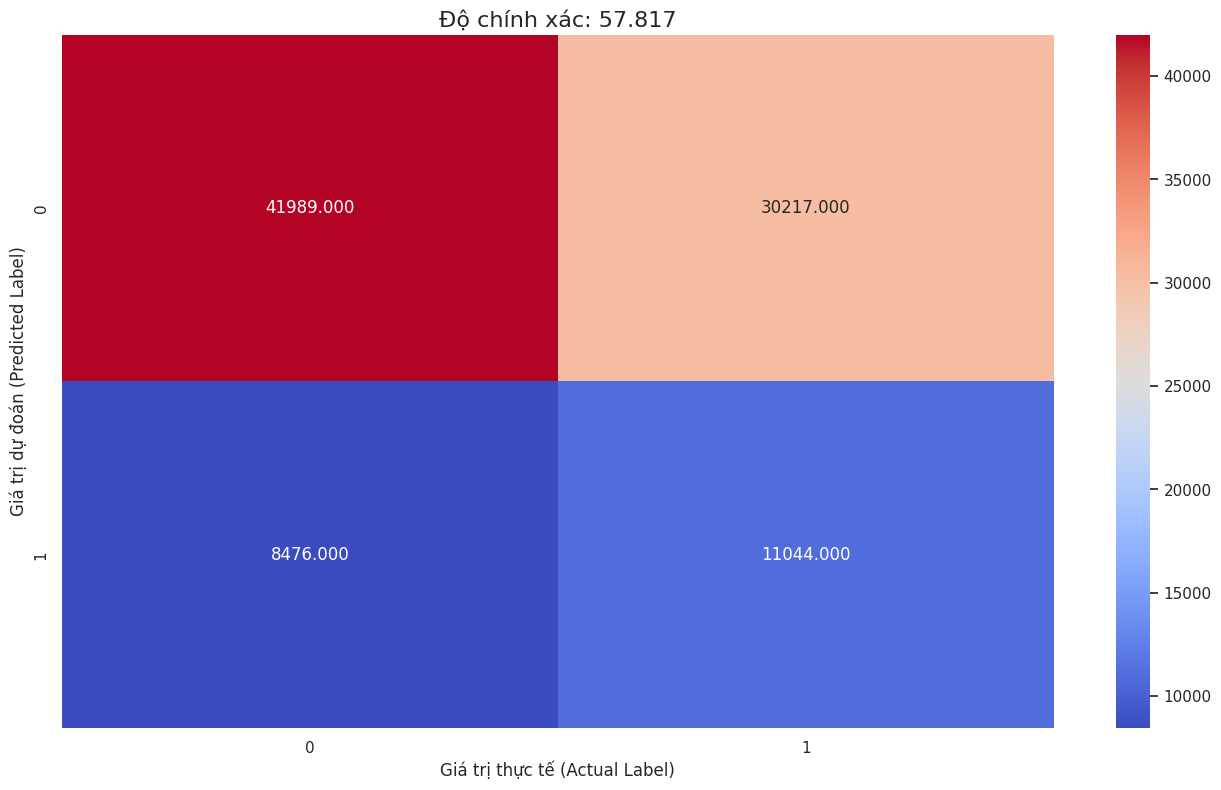

In [ ]:
# Vẽ đồ thị ma trận nhầm lẫn
plt.figure(figsize=(16, 9))
sns.heatmap(confusion_matrix(y_test_A,y_pred_A), annot=True, fmt=".3f", cmap='coolwarm')
plt.xlabel('Giá trị thực tế (Actual Label)')
plt.ylabel('Giá trị dự đoán (Predicted Label)')
title = 'Độ chính xác: {0}'.format(round(accuracy_score(y_test_A,y_pred_A) * 100, 3), '%')
plt.title(title, size=16)
plt.show()

In [ ]:
# Chuyển đổi DataFrame thành mảng NumPy
noisy_data_A = pd.DataFrame(noisy_data_A)  # Chuyển đổi về DataFrame trước
features = noisy_data_A.iloc[:, :-1].values
labels = noisy_data_A.iloc[:, -1].values

# Tên các thuộc tính
feature_names = noisy_data_A.columns[:-1]

# Độ quan trọng của các thuộc tính
importances = model1.feature_importances_
indices = np.argsort(importances)[::-1]

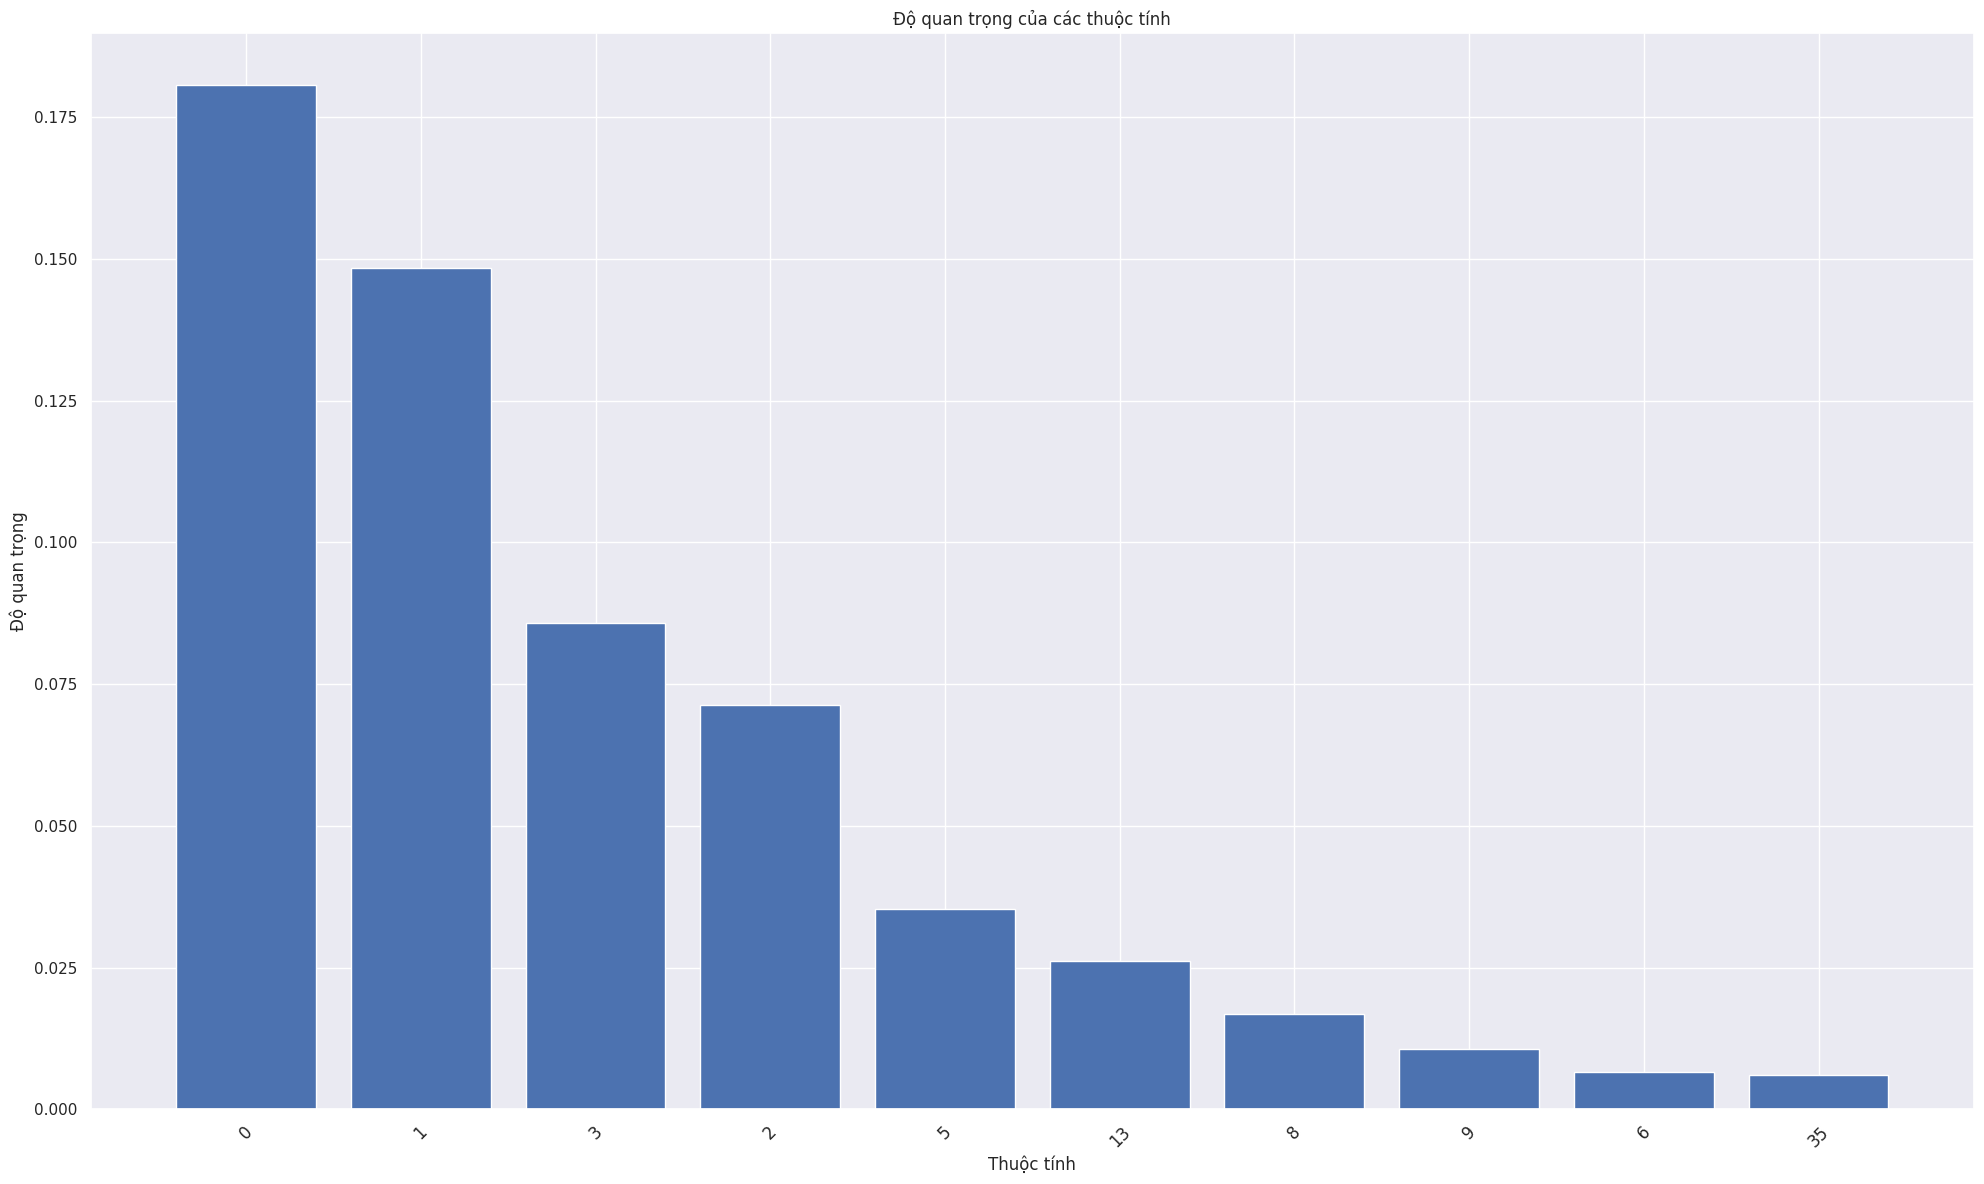

In [ ]:
# Lấy chỉ số của 10 thuộc tính quan trọng nhất
top_k = 10
top_indices = indices[:top_k]
top_importances = importances[top_indices]
top_feature_names = feature_names[top_indices]

# Biểu đồ độ quan trọng của các thuộc tính
plt.figure(figsize=(20, 12))
plt.title("Độ quan trọng của các thuộc tính")
plt.bar(range(top_k), top_importances, align="center")
plt.xticks(range(top_k), top_feature_names, rotation=45, fontsize=12)
plt.xlabel("Thuộc tính")
plt.ylabel("Độ quan trọng")
plt.tight_layout()
plt.show()

AUC (Area Under the Curve) là một phép đo được sử dụng rộng rãi trong đánh giá hiệu suất của mô hình phân loại nhị phân dựa trên biểu đồ ROC (Receiver Operating Characteristic). Biểu đồ ROC biểu thị mối quan hệ giữa tỷ lệ true positive (TPR) và tỷ lệ false positive (FPR) trên các ngưỡng khác nhau.

AUC là diện tích dưới đường cong ROC. Nó có giá trị từ 0 đến 1, và càng gần 1 thì mô hình có hiệu suất phân loại tốt hơn. Một mô hình hoàn hảo sẽ có AUC bằng 1, trong khi một mô hình ngẫu nhiên sẽ có AUC bằng 0.5.

Vì vậy, AUC là một phép đo quan trọng để đánh giá khả năng phân loại của mô hình và so sánh các mô hình khác nhau. Mô hình với AUC cao hơn có khả năng phân loại tốt hơn, đồng nghĩa với việc tỷ lệ true positive cao hơn và tỷ lệ false positive thấp hơn trên các ngưỡng khác nhau.

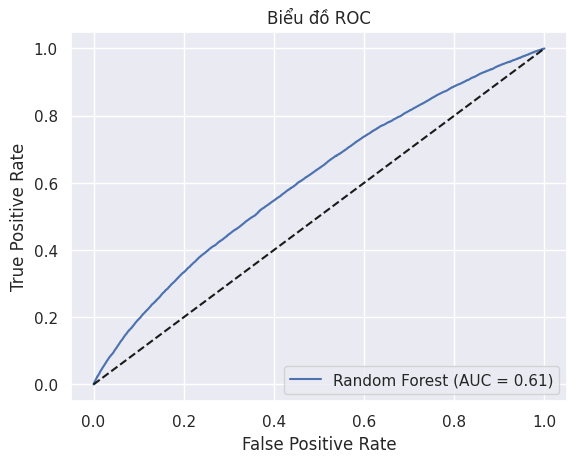

In [ ]:
# Trực quan hoá biểu đồ ROC (Receiver Operating Characteristic) để đánh giá hiệu suất của Random Forest và tìm ngưỡng phù hợp để đưa ra dự đoán.
from sklearn.metrics import roc_curve, roc_auc_score

# Dự đoán xác suất dương
y_pred_prob = model1.predict_proba(X_test_A)[:, 1]

# Tính ROC curve và AUC
fpr, tpr, thresholds = roc_curve(y_test_A, y_pred_prob)
auc = roc_auc_score(y_test_A, y_pred_prob)

# Trực quan hoá ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Đường chéo ngẫu nhiên
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Biểu đồ ROC')
plt.legend(loc='lower right')
plt.show()

Vẽ cây

In [ ]:
# Lấy cây quyết định có độ quan trọng cao nhất
best_tree_A = model1.estimators_[indices[0]]
best_tree_A

DecisionTreeClassifier(max_depth=10, max_features='sqrt',
                       random_state=1467194612)

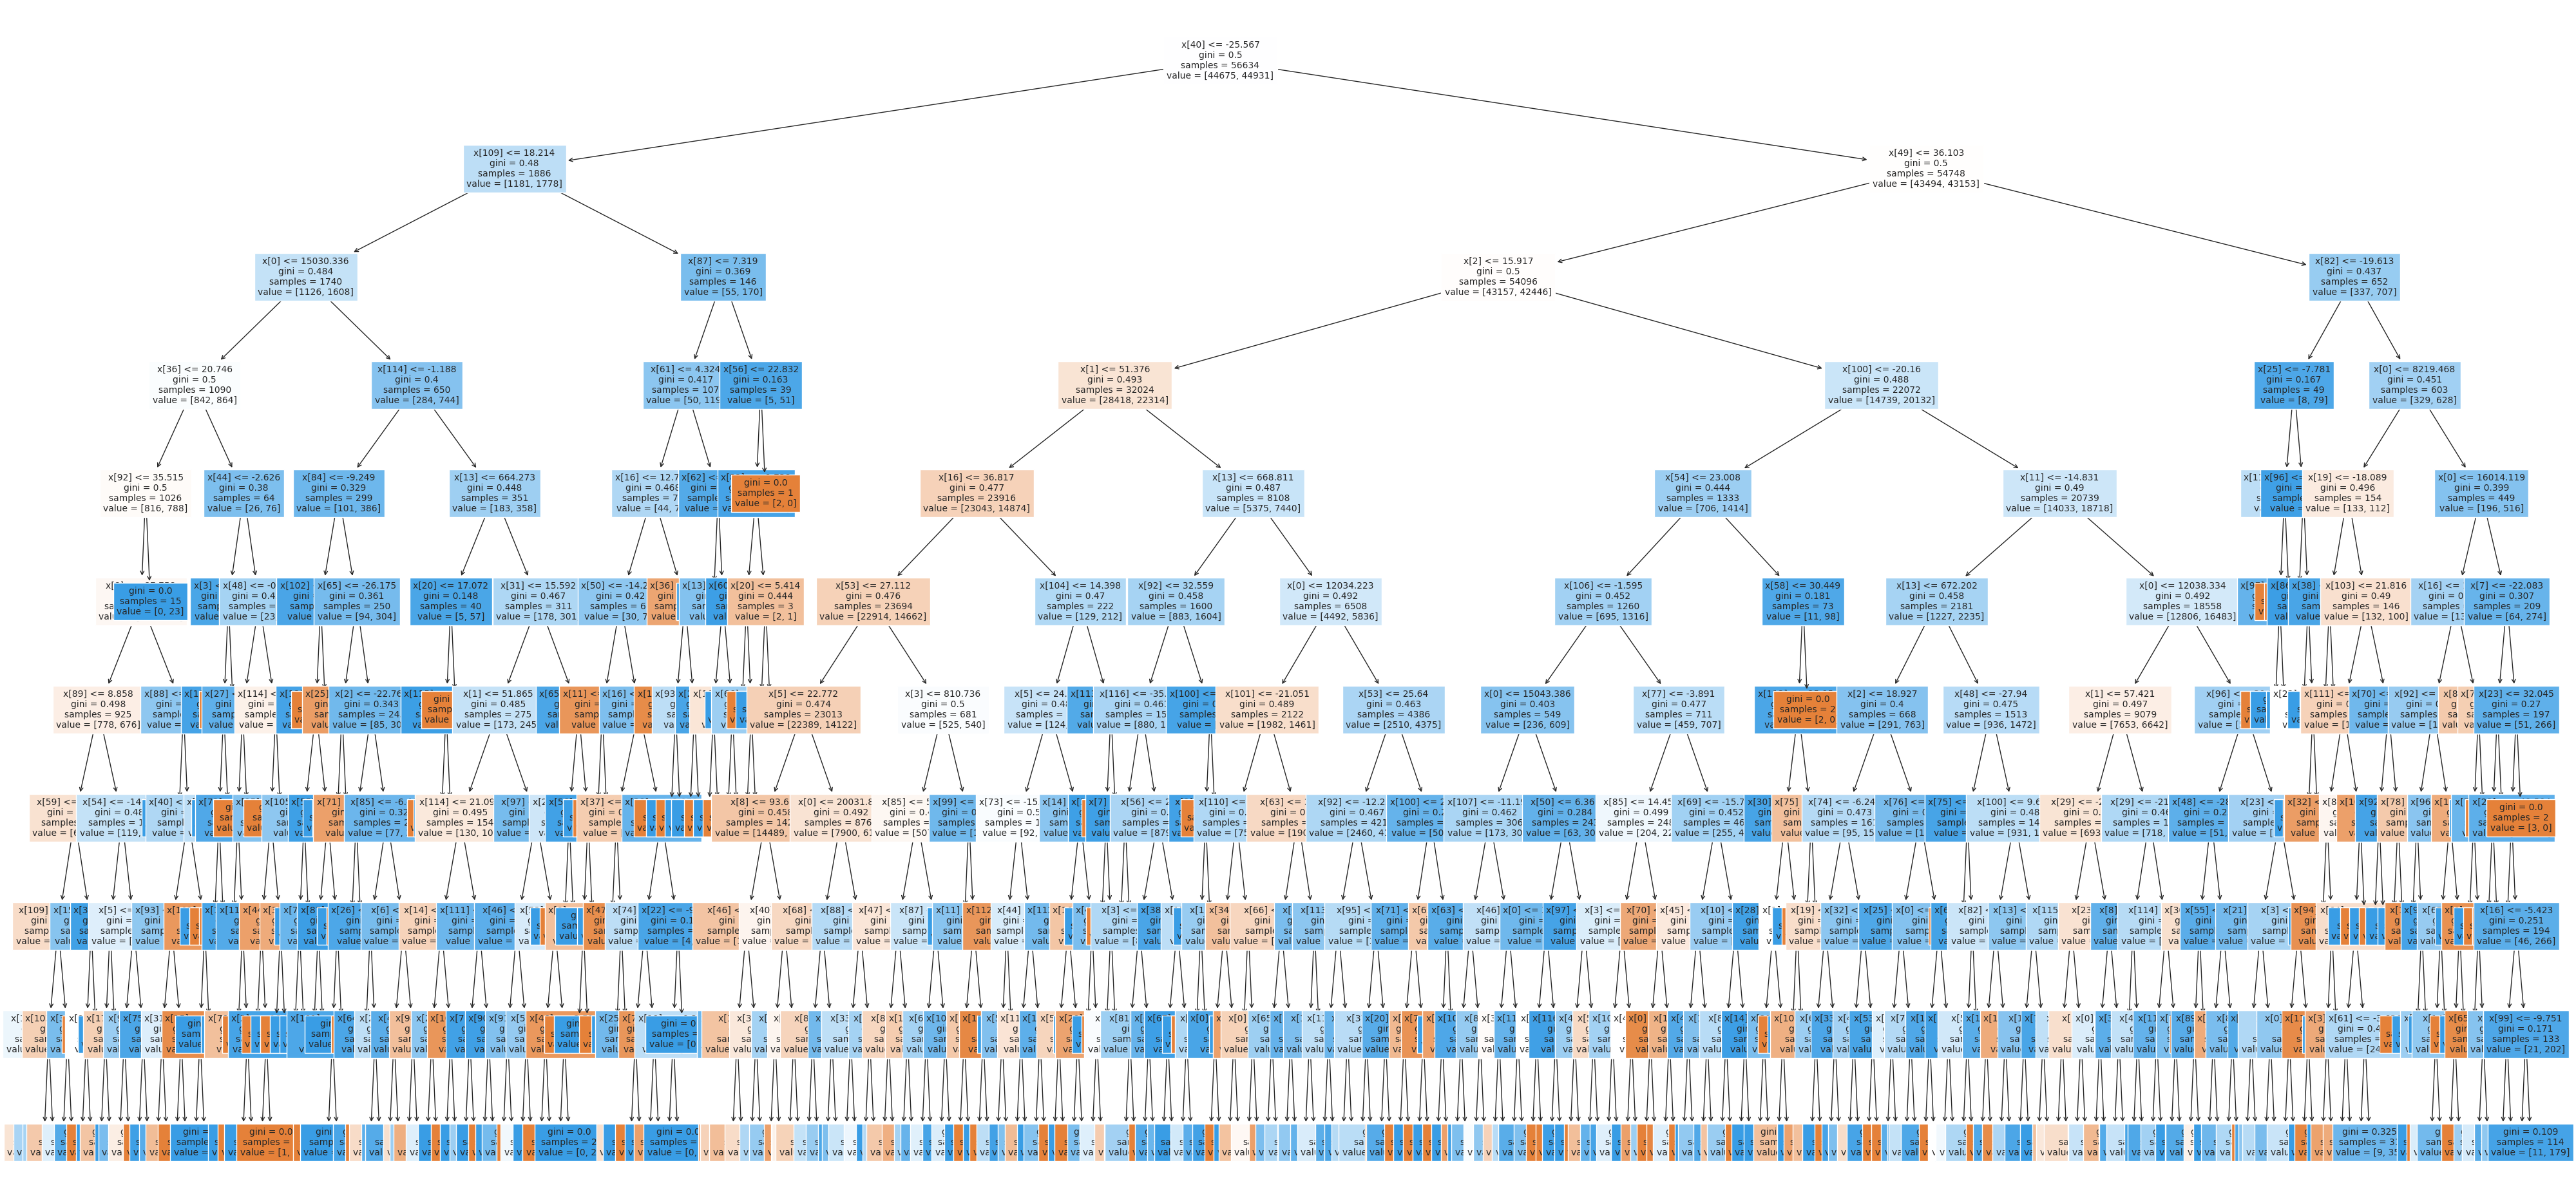

In [ ]:
# Vẽ cây ID3
from sklearn import tree

fig, ax = plt.subplots(figsize=(50, 24))
tree.plot_tree(best_tree_A, filled=True, fontsize=10)
plt.savefig('DecisionTree_BankA.png', dpi=100)
plt.show()

In [ ]:
%pip install graphviz pydotplus

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.816766 to fit


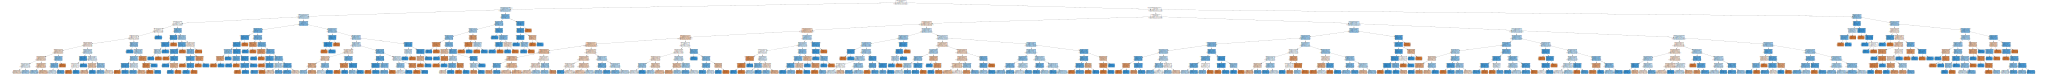

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Tạo file .dot chứa cấu trúc cây CART
dot_data_A = export_graphviz(best_tree_A, out_file=None, filled=True)

# Tạo đối tượng đồ thị từ file .dot
graph_A = graphviz.Source(dot_data_A)

# Hiển thị đồ thị CART
graph_A.render("Cay_CART_BankA", format="png")
graph_A

##### Ngân hàng B

In [ ]:
dfB = pd.read_csv('preprocessing_bankB_02.csv')
dfB.head()

loan_amnt  term  int_rate  installment  emp_length  loan_status    dti  \
0       3200    36     25.49       128.07          10            0  12.24   
1      20000    36     11.06       655.35           6            0  20.75   
2      14000    36     10.75       456.69           8            0  19.22   
3      16000    36      8.18       502.72           2            1  16.51   
4      10300    60     25.57       305.78           1            1  38.17   

   open_acc  pub_rec  revol_util  ...  addr_state_TX  addr_state_UT  \
0         9        0        25.1  ...              0              0   
1        13        0        38.1  ...              0              0   
2        14        0        66.2  ...              0              0   
3        21        1        63.0  ...              0              0   
4         9        1        31.3  ...              1              0   

   addr_state_VA  addr_state_VT  addr_state_WA  addr_state_WI  addr_state_WV  \
0              0              0              0              0              0   
1              0              0              0              0              0   
2              0              0              0              1              0   
3              0              0              0              0              0   
4              0              0              0              0              0   

   addr_state_WY  initial_list_status_w  application_type_JointApp  
0              0                      0                          0  
1              0                      0                          0  
2              0                      1                          0  
3              0                      0                          0  
4              0                      0                          0  

[5 rows x 118 columns]

In [ ]:
labelB = dfB['loan_status']
featureB = dfB.drop('loan_status', axis=1)

In [ ]:
# Chuyển đổi dữ liệu thành mảng numpy
data_B = featureB.to_numpy()

# Áp dụng Differential Privacy vào dữ liệu
epsilon = 0.1 # Chọn giá trị epsilon phù hợp
noisy_data_B = apply_differential_privacy(data_B, epsilon)
noisy_data_B

array([[ 3.20313885e+03,  6.97508091e+01,  2.31139876e+01, ...,
        -3.78729554e+00,  1.75273462e+01, -1.32959185e+01],
       [ 2.00109651e+04,  6.94474024e+01, -2.02243639e+01, ...,
        -1.40709021e+00,  3.01933848e+01,  7.77570943e+00],
       [ 1.39959617e+04,  4.70729057e+01,  1.14792465e+01, ...,
         1.31634460e+01, -1.96899060e+00, -3.33502542e-02],
       ...,
       [ 1.01926341e+04,  4.08199403e+01,  2.50183533e+01, ...,
        -3.17413542e+00,  1.32894077e+01, -9.20495275e+00],
       [ 1.19987507e+04,  7.53199928e+01, -4.27729012e+00, ...,
        -4.51830385e+01,  8.07469308e+00,  1.83942322e+01],
       [ 2.49853881e+04,  7.11360654e+00,  1.02135969e+01, ...,
        -1.93692221e+01, -3.12338771e+00, -1.25744211e+01]])

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(noisy_data_B, labelB, test_size=0.3, random_state=42)

In [ ]:
ns=NearMiss()
X_train_B_ns,y_train_B_ns=ns.fit_resample(X_train_B,y_train_B)
print("The number of classes before fit {}".format(Counter(y_train_B)))
print("The number of classes after fit {}".format(Counter(y_train_B_ns)))

The number of classes before fit Counter({0: 168693, 1: 45528})
The number of classes after fit Counter({0: 45528, 1: 45528})


In [ ]:
startB_ID3 = time.time()
model2 = RandomForestClassifier(n_estimators=100, max_depth=10)
model2.fit(X_train_B_ns,y_train_B_ns)
endB_ID3 = time.time()
timeB_ID3 = timedelta(seconds=round(endB_ID3 - startB_ID3, 3))
print("Thời gian chạy: ", timeB_ID3)

Thời gian chạy:  0:02:47.924000


In [ ]:
y_pred_B = model2.predict(X_test_B)
print("Ma trận nhầm lẫn: \n",confusion_matrix(y_test_B,y_pred_B))
print('\n')
print("Độ chính xác thuật toán: \n", round(accuracy_score(y_test_B,y_pred_B) * 100, 3))
print('\n')
print("Đánh giá mô hình phân lớp: \n",classification_report(y_test_B,y_pred_B))

Ma trận nhầm lẫn: 
 [[42379 30094]
 [ 8423 10913]]


Độ chính xác thuật toán: 
 58.047


Đánh giá mô hình phân lớp: 
               precision    recall  f1-score   support

           0       0.83      0.58      0.69     72473
           1       0.27      0.56      0.36     19336

    accuracy                           0.58     91809
   macro avg       0.55      0.57      0.52     91809
weighted avg       0.71      0.58      0.62     91809



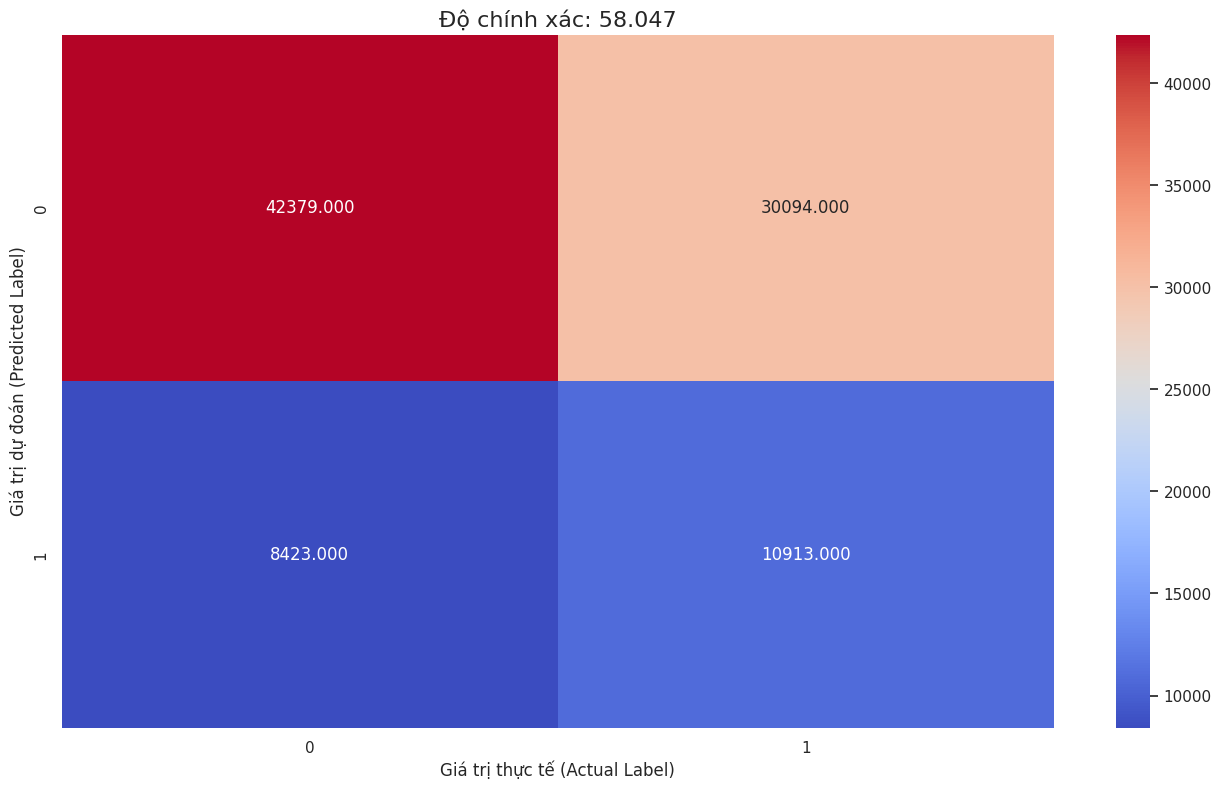

In [ ]:
# Vẽ đồ thị ma trận nhầm lẫn
plt.figure(figsize=(16, 9))
sns.heatmap(confusion_matrix(y_test_B,y_pred_B), annot=True, fmt=".3f", cmap='coolwarm')
plt.xlabel('Giá trị thực tế (Actual Label)')
plt.ylabel('Giá trị dự đoán (Predicted Label)')
title = 'Độ chính xác: {0}'.format(round(accuracy_score(y_test_B,y_pred_B) * 100, 3), '%')
plt.title(title, size=16)
plt.show()

In [ ]:
# Chuyển đổi DataFrame thành mảng NumPy
noisy_data_B = pd.DataFrame(noisy_data_B)  # Chuyển đổi về DataFrame trước
features = noisy_data_B.iloc[:, :-1].values
labels = noisy_data_B.iloc[:, -1].values

# Tên các thuộc tính
feature_names = noisy_data_B.columns[:-1]

# Độ quan trọng của các thuộc tính
importances = model1.feature_importances_
indices = np.argsort(importances)[::-1]

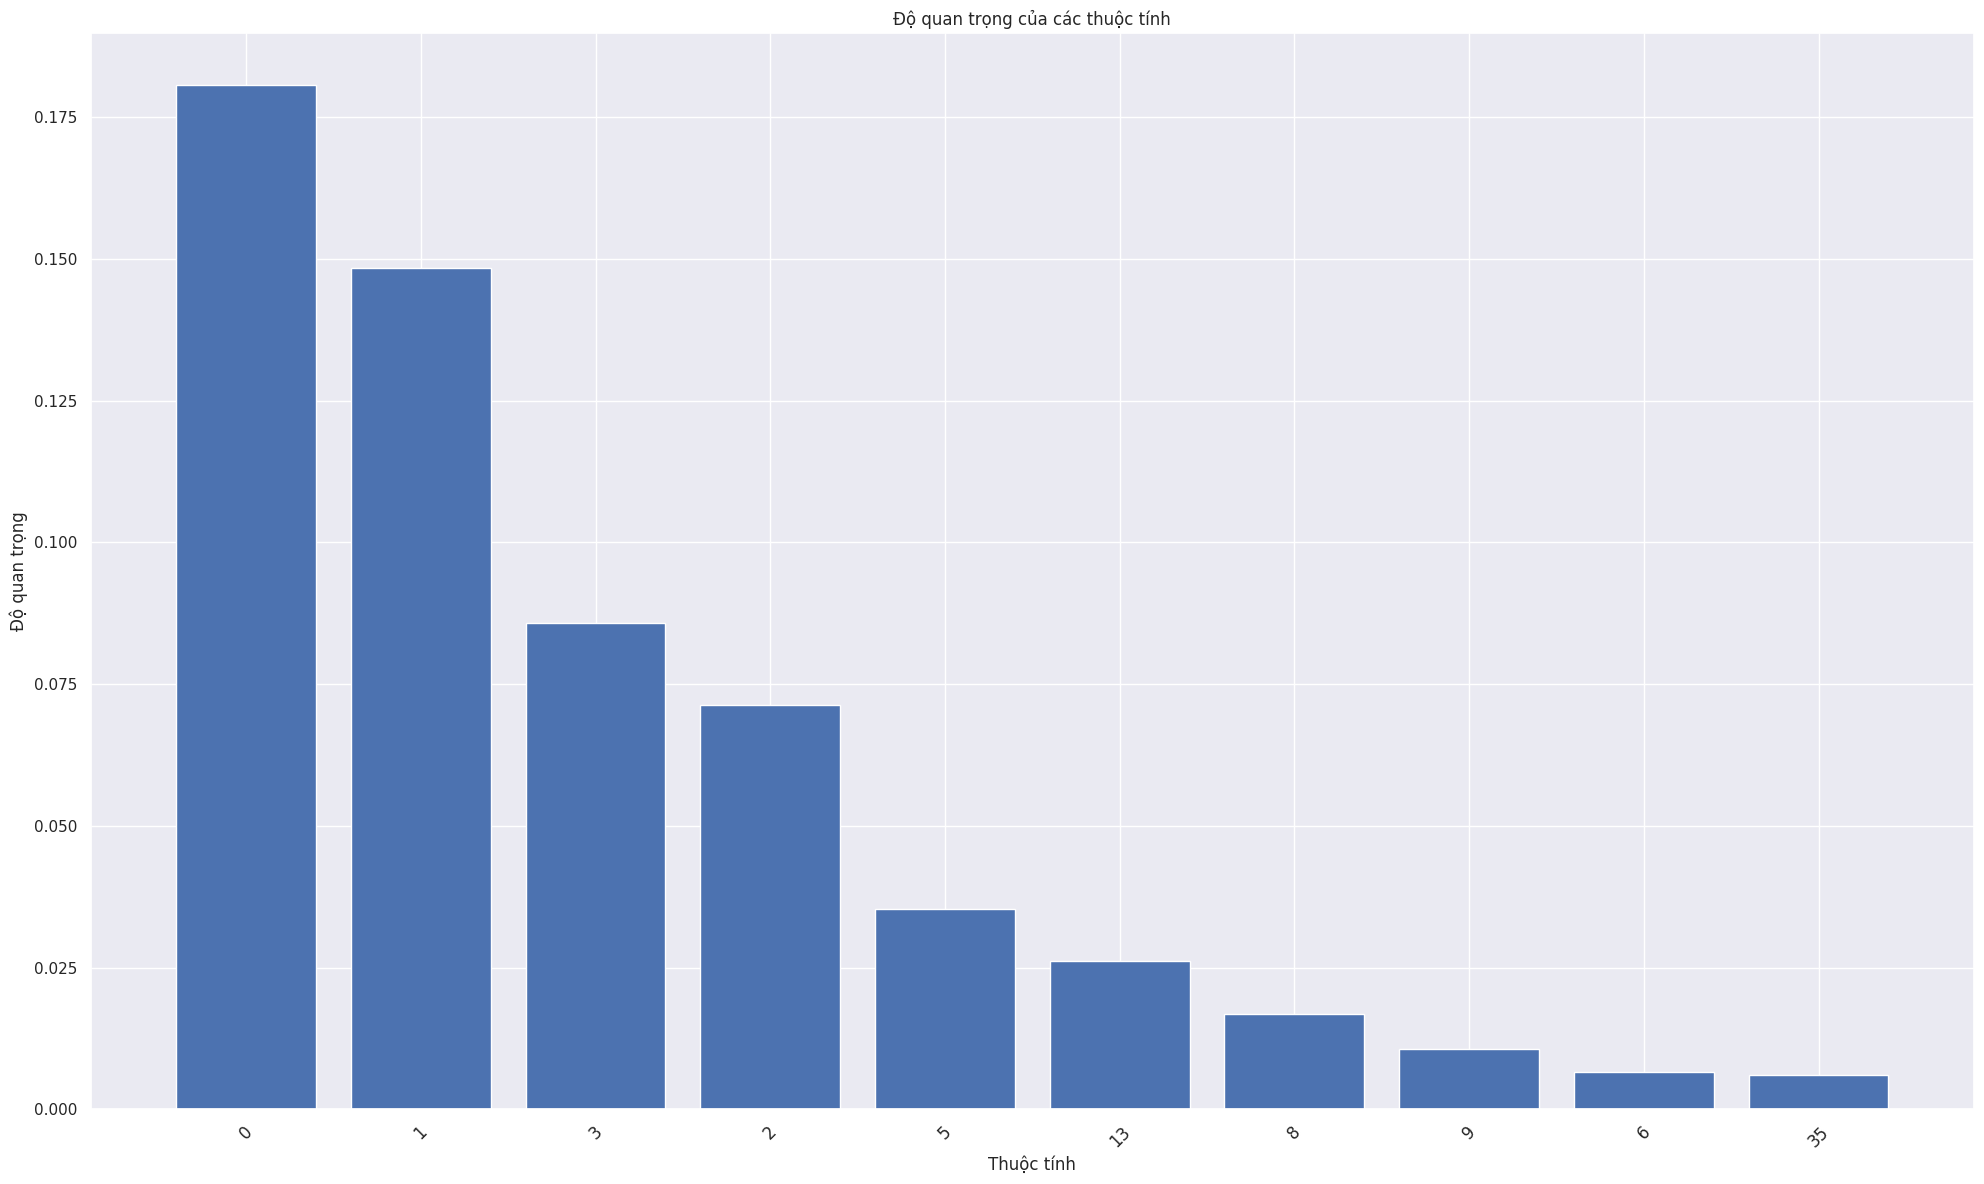

In [ ]:
# Lấy chỉ số của 10 thuộc tính quan trọng nhất
top_k = 10
top_indices = indices[:top_k]
top_importances = importances[top_indices]
top_feature_names = feature_names[top_indices]

# Biểu đồ độ quan trọng của các thuộc tính
plt.figure(figsize=(20, 12))
plt.title("Độ quan trọng của các thuộc tính")
plt.bar(range(top_k), top_importances, align="center")
plt.xticks(range(top_k), top_feature_names, rotation=45, fontsize=12)
plt.xlabel("Thuộc tính")
plt.ylabel("Độ quan trọng")
plt.tight_layout()
plt.show()

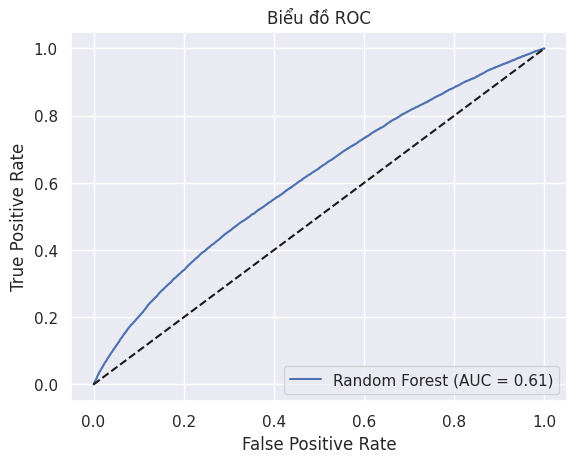

In [ ]:
# Trực quan hoá biểu đồ ROC (Receiver Operating Characteristic) để đánh giá hiệu suất của Random Forest và tìm ngưỡng phù hợp để đưa ra dự đoán.
from sklearn.metrics import roc_curve, roc_auc_score

# Dự đoán xác suất dương
y_pred_prob = model2.predict_proba(X_test_B)[:, 1]

# Tính ROC curve và AUC
fpr, tpr, thresholds = roc_curve(y_test_B, y_pred_prob)
auc = roc_auc_score(y_test_B, y_pred_prob)

# Trực quan hoá ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Đường chéo ngẫu nhiên
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Biểu đồ ROC')
plt.legend(loc='lower right')
plt.show()

Vẽ cây

In [ ]:
# Lấy cây quyết định có độ quan trọng cao nhất
best_tree_B = model2.estimators_[indices[0]]
best_tree_B

DecisionTreeClassifier(max_depth=10, max_features='sqrt',
                       random_state=2046290923)

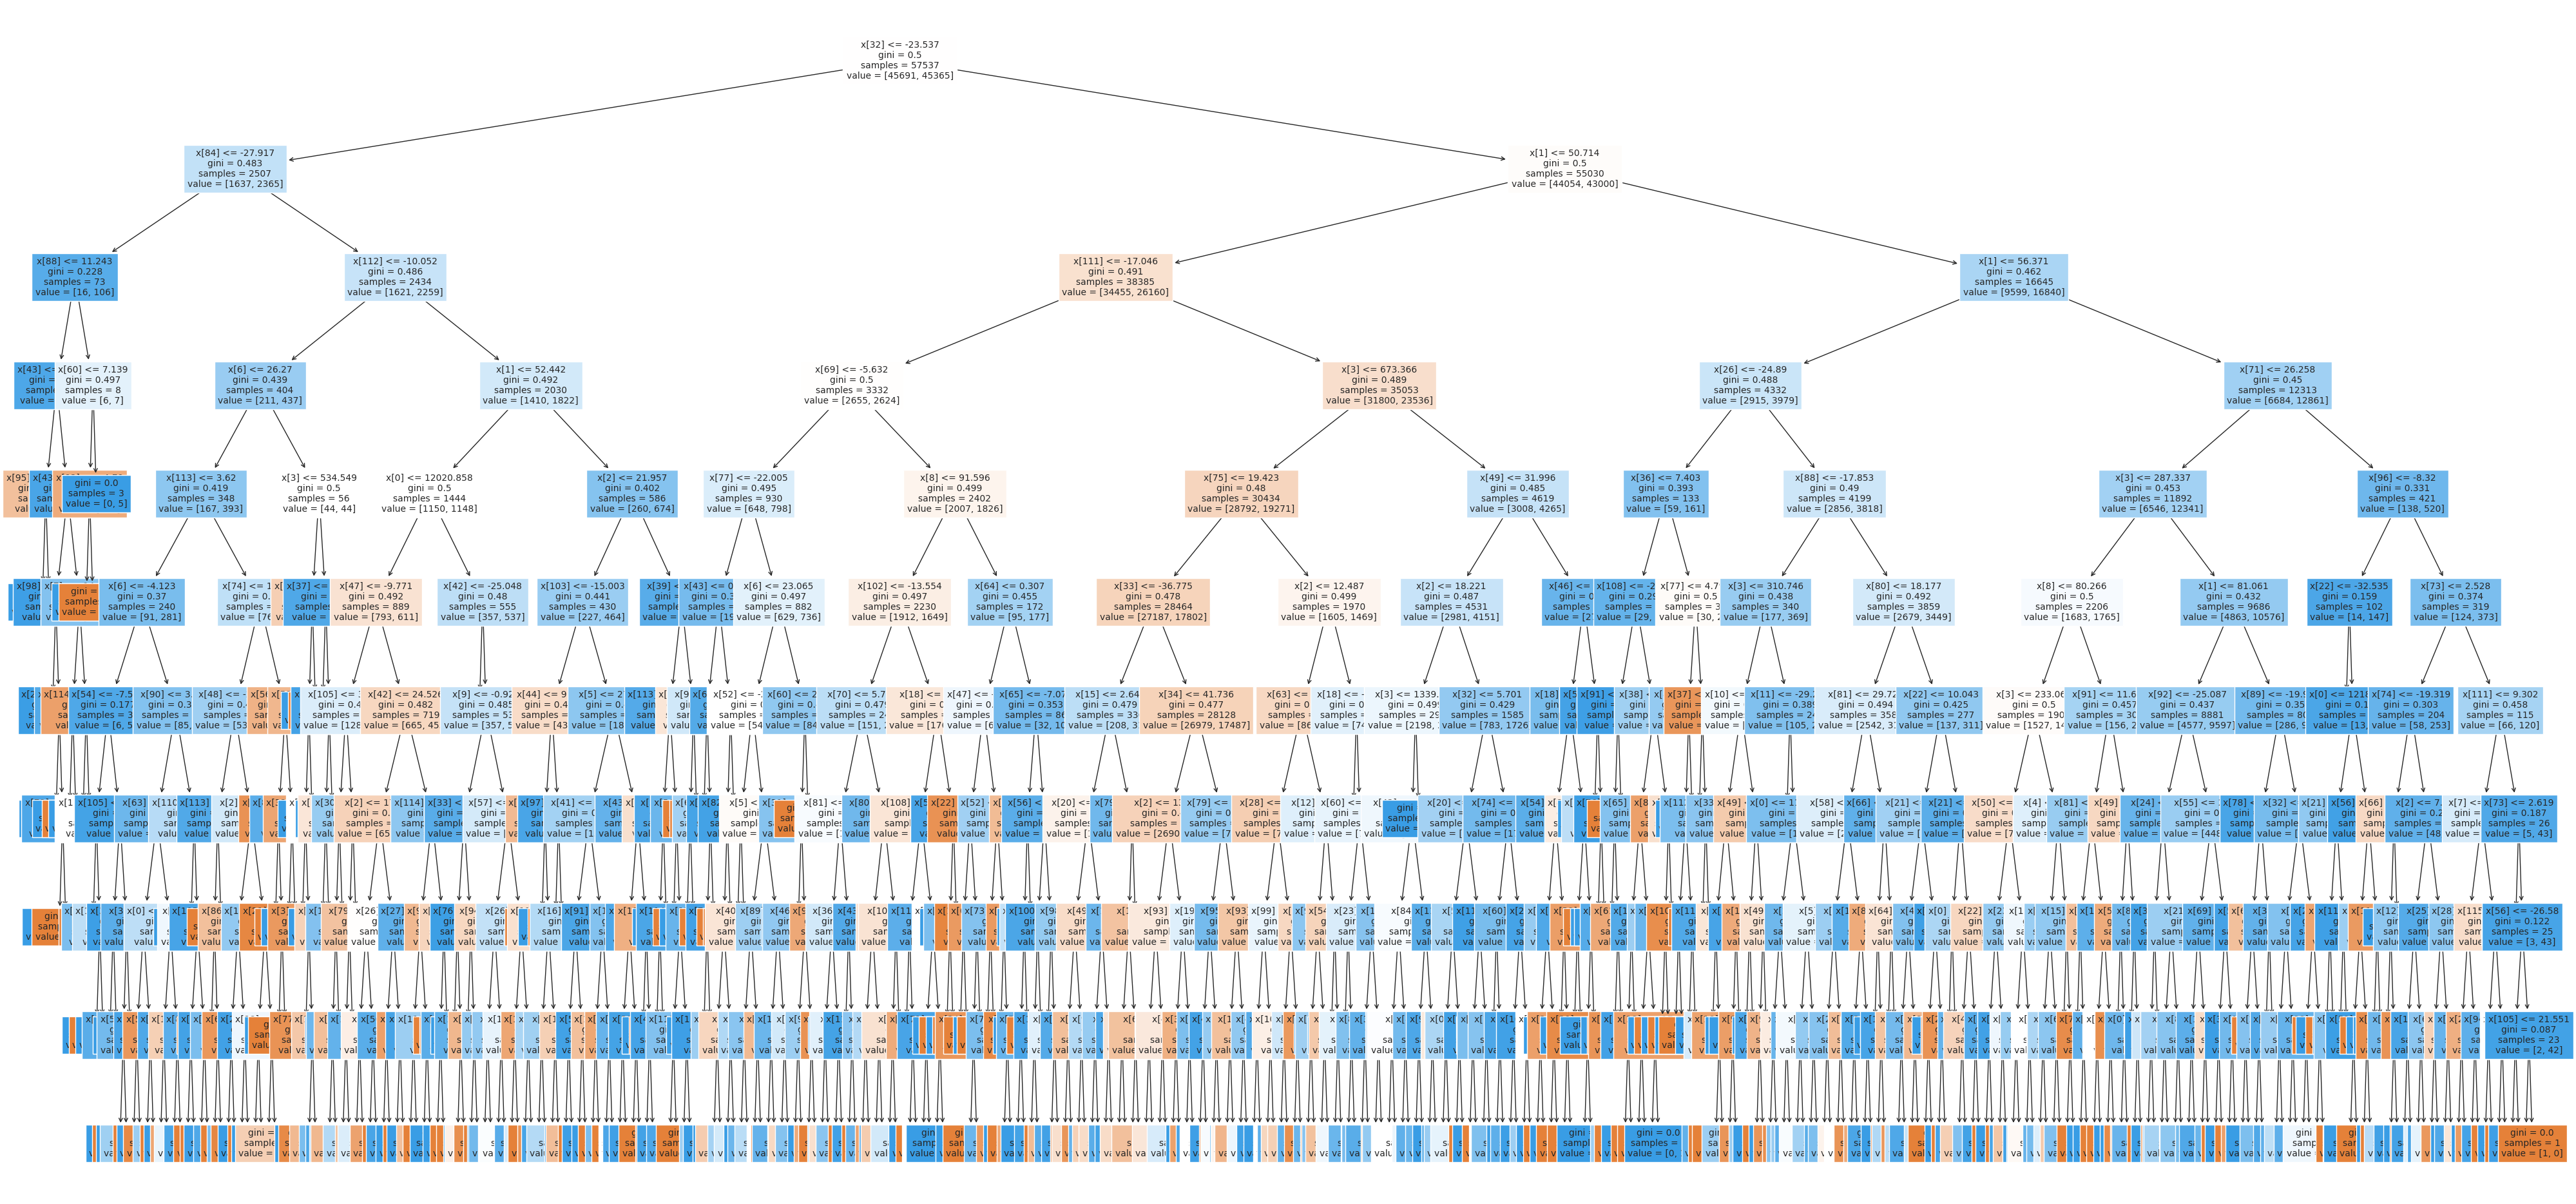

In [ ]:
# Vẽ cây ID3
from sklearn import tree

fig, ax = plt.subplots(figsize=(50, 24))
tree.plot_tree(best_tree_B, filled=True, fontsize=10)
plt.savefig('DecisionTree_BankB.png', dpi=100)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.591387 to fit


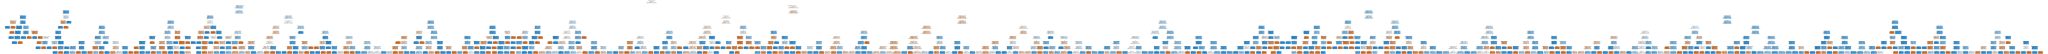

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Tạo file .dot chứa cấu trúc cây CART
dot_data_B = export_graphviz(best_tree_B, out_file=None, filled=True)

# Tạo đối tượng đồ thị từ file .dot
graph_B = graphviz.Source(dot_data_B)

# Hiển thị đồ thị CART
graph_B.render("Cay_CART_BankB", format="png")
graph_B

#### 2. Aggregate 2 ngân hàng

Kết hợp dữ liệu

In [ ]:
merged_data = pd.concat([noisy_data_A, noisy_data_B], ignore_index=True)
merged_data = merged_data.dropna(axis=1)
merged_data

0          1          2           3          4          5    \
0       15997.266377  53.076490  27.368096  477.903131  21.929817   4.292096   
1       20028.149157  53.044001  13.336649  632.466717 -10.586816  11.652597   
2        2975.116822  38.534282  33.990514  148.786972  14.653647  15.739483   
3        9002.206462  33.467035   0.146165  283.420890 -42.040786  40.353680   
4       35001.814633  61.045673  20.599610  754.287956  19.279605  -6.619018   
...              ...        ...        ...         ...        ...        ...   
611777   6997.835814  39.562561  10.365420  235.411945  13.173519   0.275460   
611778  12060.238682  17.662500  11.532319  431.540769   2.874461  29.868723   
611779  10192.634090  40.819940  25.018353  349.788616   1.872085   4.639449   
611780  11998.750656  75.319993  -4.277290  268.012906  -3.763821  20.225649   
611781  24985.388079   7.113607  10.213597  805.945456 -26.566637  60.637600   

              6          7           8          9    ...        107  \
0      -14.749566  43.042736   50.825925  -7.854110  ...   5.698248   
1       -7.981105  16.042135   14.688620  40.768543  ... -12.494917   
2        7.602301 -31.395442   73.181573   8.712319  ... -13.901568   
3      -14.686370   0.967118   74.488913  -8.112031  ...   2.042777   
4       -6.685595 -28.141333    7.741900  56.749488  ...   5.159271   
...           ...        ...         ...        ...  ...        ...   
611777  29.103435  -2.057864   51.158284  29.693073  ...   2.205196   
611778 -14.730128  -6.277281   59.305231  25.255256  ... -11.864258   
611779  12.162402  12.721030   87.544080  32.929896  ...  14.748340   
611780  11.731278   2.670912   40.495471  16.551107  ...   3.750016   
611781   6.065022 -18.381326  106.701817   1.013627  ...  -2.765786   

              108        109        110        111        112        113  \
0       -9.060826  -1.254123  -5.933461   1.132849   9.929101  -2.716350   
1       -9.025765   5.796350  10.352215  19.344710   4.572515  -1.911568   
2        6.634932 -25.651100   0.641289  -9.975176   4.872043  -9.453533   
3       -0.412770  10.138291  24.475467 -15.431117   2.922278  -2.261389   
4       -6.651062  -1.258305   4.105897  -0.177086  12.241336   2.352766   
...           ...        ...        ...        ...        ...        ...   
611777  -2.730374  -6.462959   0.551834 -11.356836   6.051325   0.545937   
611778   0.834701  38.834627   3.052325 -24.506467  -5.763092 -15.337941   
611779  28.005780  -3.665690  10.274503  30.136695   4.806073 -16.195281   
611780  -0.994035  -3.929669  11.306738  -2.744571  15.540862  -2.133468   
611781 -17.405729   9.419084 -12.430717   8.178052  39.702416  -1.140615   

              114        115        116  
0      -11.190828  -1.755599  -2.114853  
1       -2.186894  12.357134  -3.100568  
2        0.129009   2.915615   0.029659  
3       -5.398277  14.991167  -8.564082  
4        1.807590  -7.059523  -2.144076  
...           ...        ...        ...  
611777 -14.477330  -6.771153  -5.861174  
611778   5.358795  50.489506  -2.270598  
611779  -3.174135  13.289408  -9.204953  
611780 -45.183039   8.074693  18.394232  
611781 -19.369222  -3.123388 -12.574421  

[611782 rows x 117 columns]

In [ ]:
# Kết hợp nhãn cho biến label
labelA = pd.DataFrame(labelA)
labelB = pd.DataFrame(labelB)
label_data = pd.concat([labelA, labelB], axis=0)
label_data.columns = ['loan_status']
label_data

loan_status
0                 1
1                 0
2                 0
3                 0
4                 0
...             ...
306025            0
306026            0
306027            0
306028            0
306029            0

[611782 rows x 1 columns]

In [ ]:
# Gán label và feature
label = label_data
feature = merged_data

In [ ]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(merged_data, label, test_size=0.3, random_state=42)

In [ ]:
ns=NearMiss()
X_train_ns,y_train_ns=ns.fit_resample(X_train,y_train)
print("The number of classes before fit {}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fit Counter({'loan_status': 1})
The number of classes after fit Counter({'loan_status': 1})


In [ ]:
start_ID3 = time.time()
model = RandomForestClassifier(n_estimators=100, max_depth=10)
model.fit(X_train_ns,y_train_ns)
end_ID3 = time.time()
time_ID3 = timedelta(seconds=round(end_ID3 - start_ID3, 3))
print("Thời gian chạy: ", time_ID3)

Thời gian chạy:  0:04:23.541000


In [ ]:
y_pred = model.predict(X_test)
print("Ma trận nhầm lẫn: \n",confusion_matrix(y_test,y_pred))
print('\n')
print("Độ chính xác thuật toán: \n", round(accuracy_score(y_test,y_pred) * 100, 3))
print('\n')
print("Đánh giá mô hình phân lớp: \n",classification_report(y_test,y_pred))

Ma trận nhầm lẫn: 
 [[84193 60448]
 [16623 22271]]


Độ chính xác thuật toán: 
 58.007


Đánh giá mô hình phân lớp: 
               precision    recall  f1-score   support

           0       0.84      0.58      0.69    144641
           1       0.27      0.57      0.37     38894

    accuracy                           0.58    183535
   macro avg       0.55      0.58      0.53    183535
weighted avg       0.72      0.58      0.62    183535



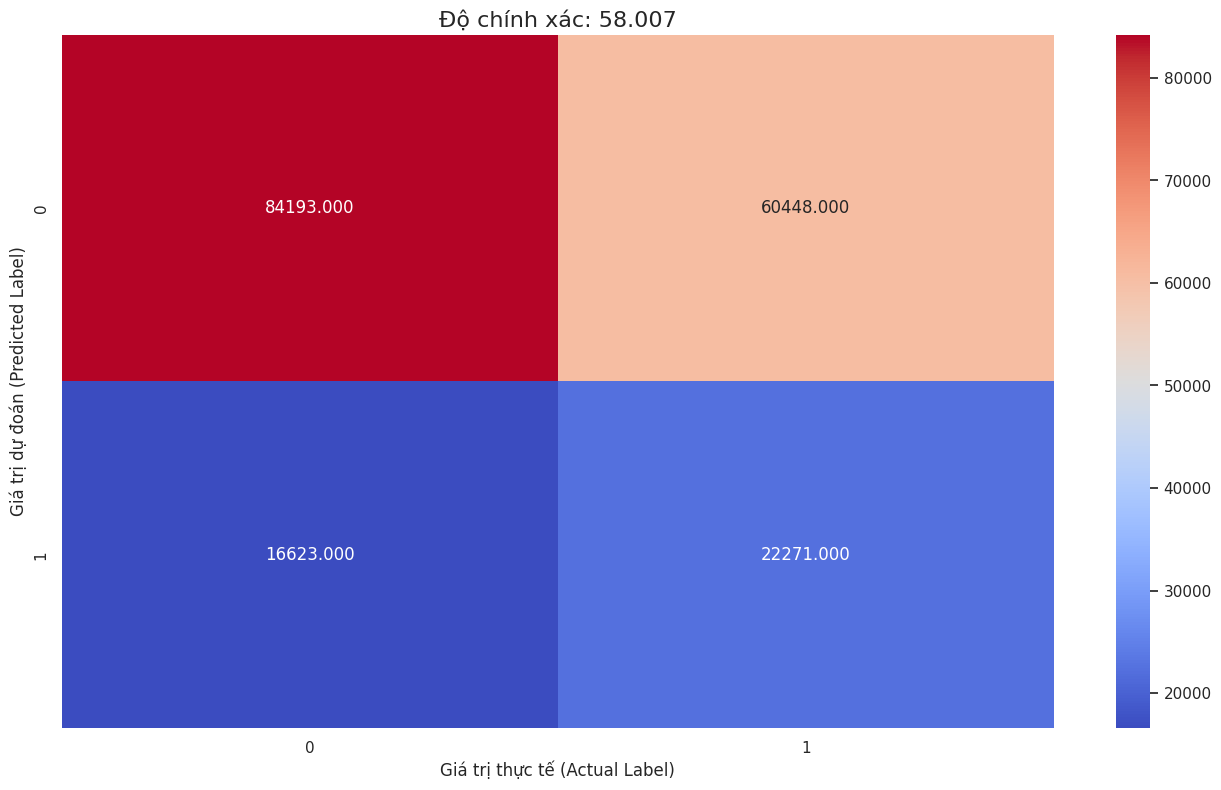

In [ ]:
# Vẽ đồ thị ma trận nhầm lẫn
plt.figure(figsize=(16, 9))
sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".3f", cmap='coolwarm')
plt.xlabel('Giá trị thực tế (Actual Label)')
plt.ylabel('Giá trị dự đoán (Predicted Label)')
title = 'Độ chính xác: {0}'.format(round(accuracy_score(y_test,y_pred) * 100, 3), '%')
plt.title(title, size=16)
plt.show()

In [ ]:
# Chuyển đổi DataFrame thành mảng NumPy
merged_data = pd.DataFrame(merged_data)  # Chuyển đổi về DataFrame trước
features = merged_data.iloc[:, :-1].values
labels = merged_data.iloc[:, -1].values

# Tên các thuộc tính
feature_names = merged_data.columns[:-1]
 
# Độ quan trọng của các thuộc tính
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

In [ ]:
# Lấy chỉ số của 10 thuộc tính quan trọng nhất
top_k = 10
top_indices = indices[:top_k]
top_importances = importances[top_indices]
top_feature_names = feature_names[top_indices]

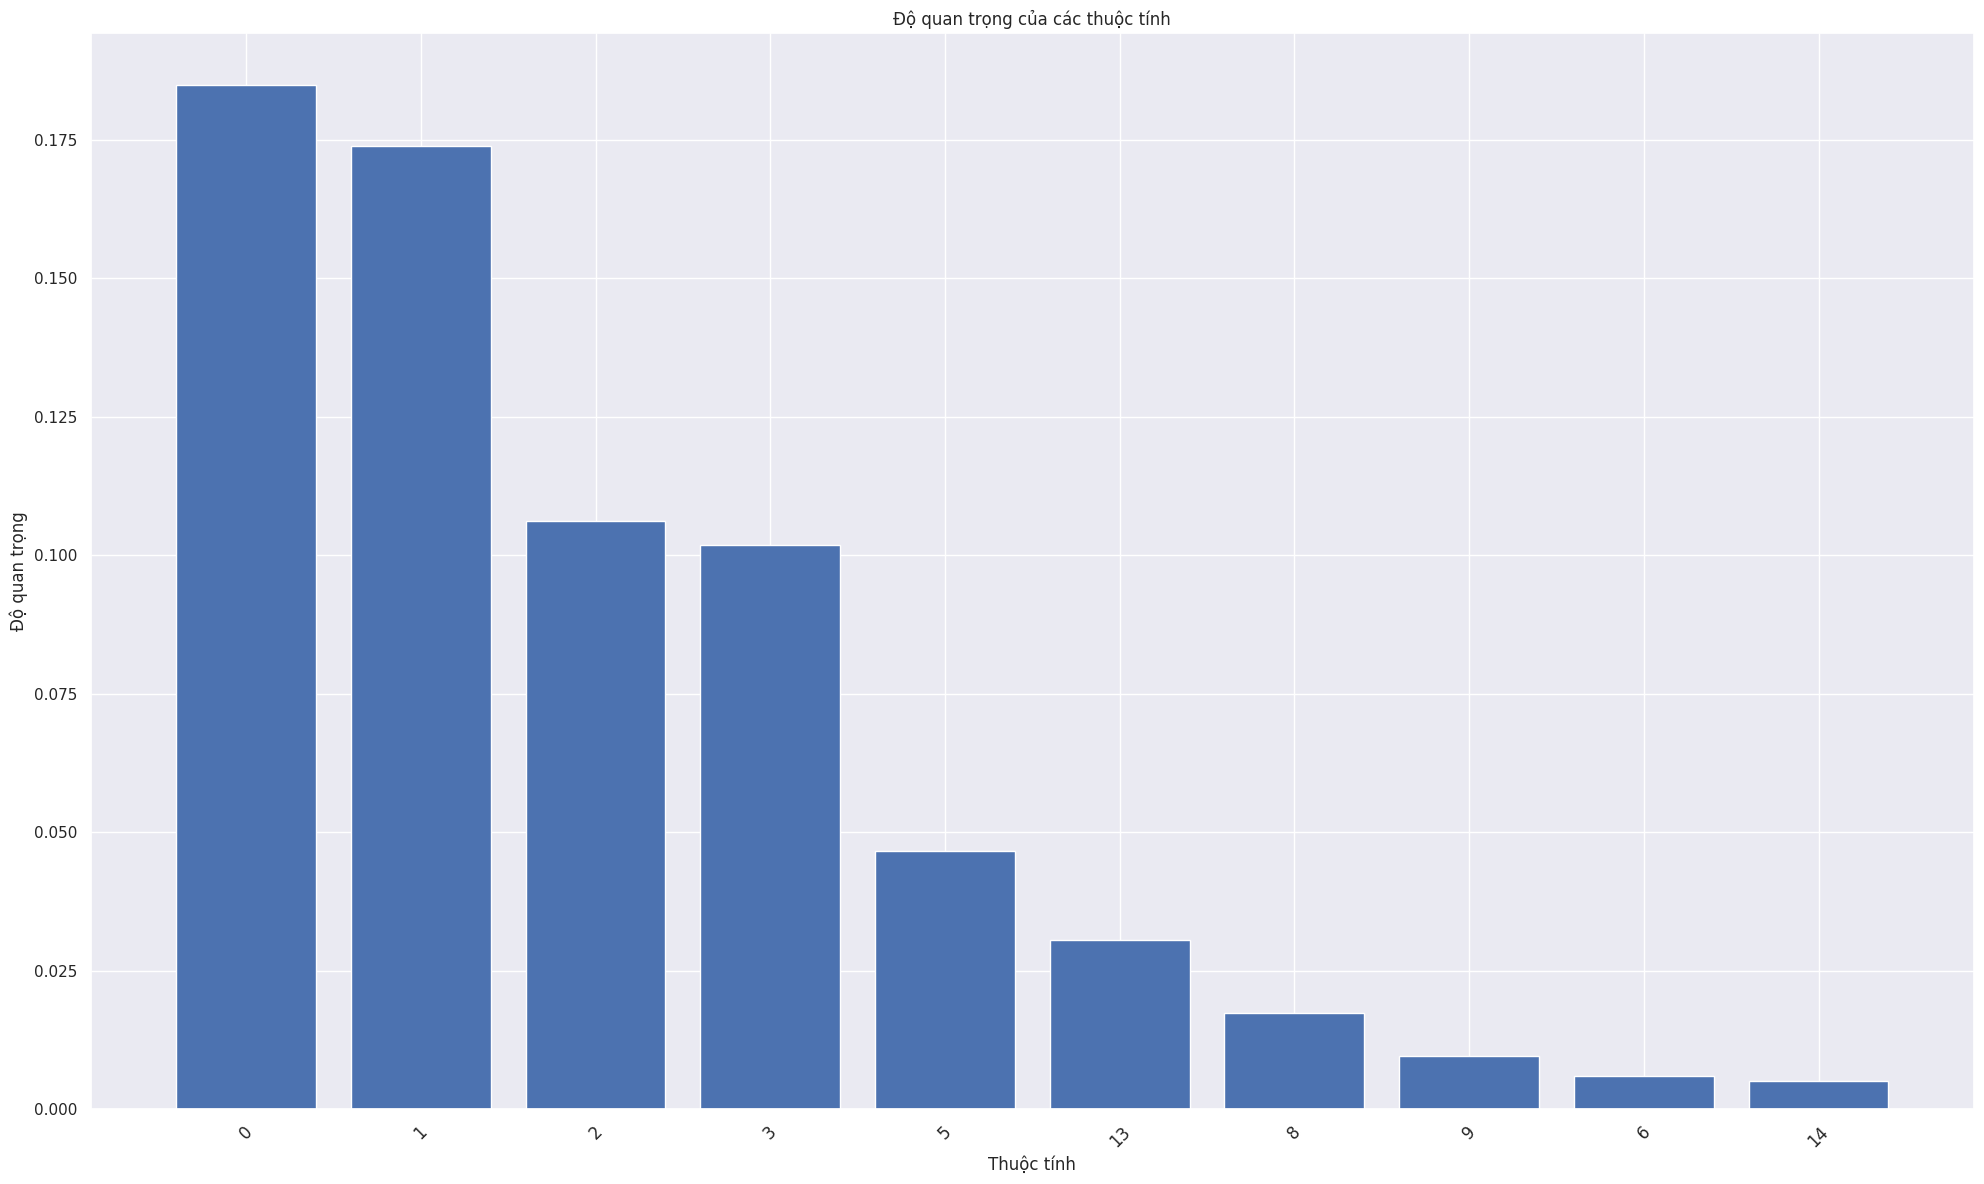

In [ ]:
# Biểu đồ độ quan trọng của các thuộc tính
plt.figure(figsize=(20, 12))
plt.title("Độ quan trọng của các thuộc tính")
plt.bar(range(top_k), top_importances, align="center")
plt.xticks(range(top_k), top_feature_names, rotation=45, fontsize=12)
plt.xlabel("Thuộc tính")
plt.ylabel("Độ quan trọng")
plt.tight_layout()
plt.show()

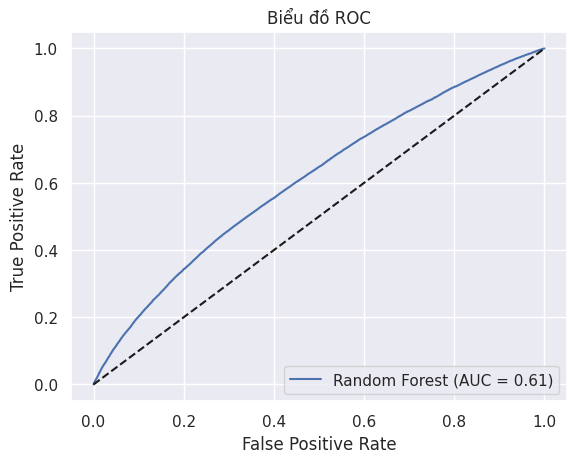

In [ ]:
# Trực quan hoá biểu đồ ROC (Receiver Operating Characteristic) để đánh giá hiệu suất của Random Forest và tìm ngưỡng phù hợp để đưa ra dự đoán.
from sklearn.metrics import roc_curve, roc_auc_score

# Dự đoán xác suất dương
y_pred_prob = model.predict_proba(X_test)[:, 1]

# Tính ROC curve và AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

# Trực quan hoá ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Đường chéo ngẫu nhiên
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Biểu đồ ROC')
plt.legend(loc='lower right')
plt.show()

Vẽ cây

In [ ]:
# Lấy cây quyết định có độ quan trọng cao nhất
best_tree = model.estimators_[indices[0]]
best_tree

DecisionTreeClassifier(max_depth=10, max_features='sqrt',
                       random_state=631874616)

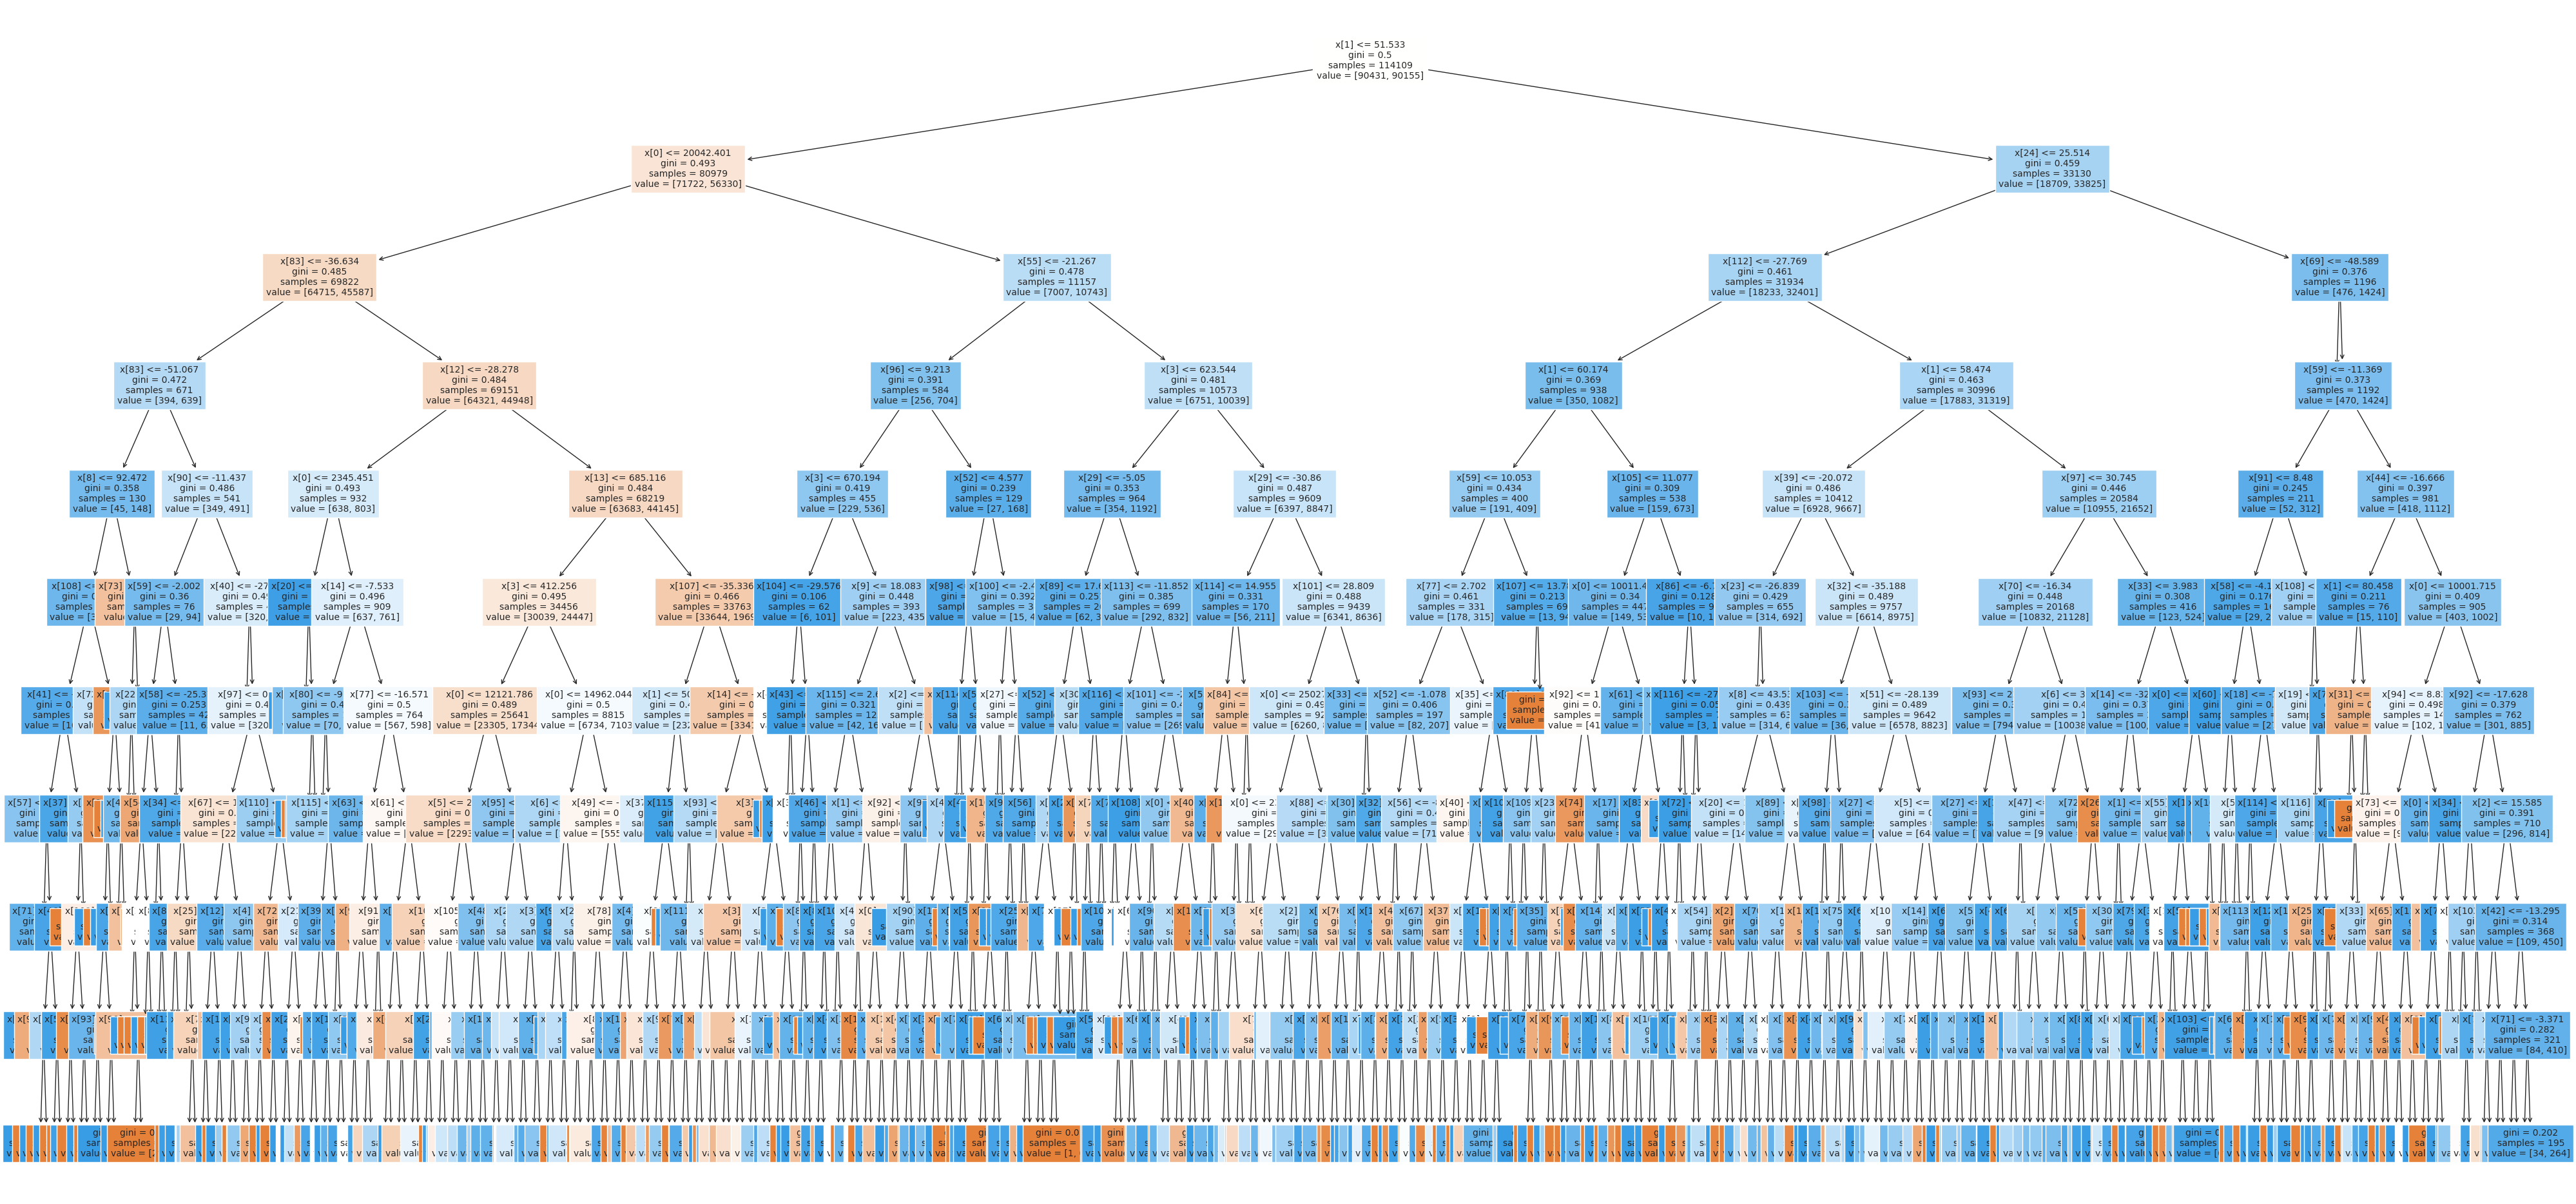

In [ ]:
# Vẽ cây ID3
from sklearn import tree

fig, ax = plt.subplots(figsize=(50, 24))
tree.plot_tree(best_tree, filled=True, fontsize=10)
plt.savefig('DecisionTree_Bank.png', dpi=100)
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.587275 to fit


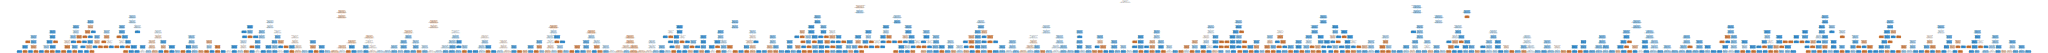

In [ ]:
from sklearn.tree import export_graphviz
import graphviz

# Tạo file .dot chứa cấu trúc cây CART
dot_data = export_graphviz(best_tree, out_file=None, filled=True)

# Tạo đối tượng đồ thị từ file .dot
graph = graphviz.Source(dot_data)

# Hiển thị đồ thị CART
graph.render("Cay_CART_Bank", format="png")
graph

## **Đánh giá thuật toán**

### Thời gian chạy

In [ ]:
# Dữ liệu thời gian chạy thuật toán trên các ngân hàng
timeA_ID3 = [pd.Timedelta(minutes=2), pd.Timedelta(minutes=3), pd.Timedelta(minutes=4),
             pd.Timedelta(minutes=2), pd.Timedelta(minutes=3)]
timeB_ID3 = [pd.Timedelta(minutes=1), pd.Timedelta(minutes=2), pd.Timedelta(minutes=3),
             pd.Timedelta(minutes=2), pd.Timedelta(minutes=3)]
time_ID3 = timeA_ID3 + timeB_ID3

# Chuyển đổi timedelta thành số (giây)
timeA_ID3 = [t.total_seconds() for t in timeA_ID3]
timeB_ID3 = [t.total_seconds() for t in timeB_ID3]
time_ID3 = [t.total_seconds() for t in time_ID3]

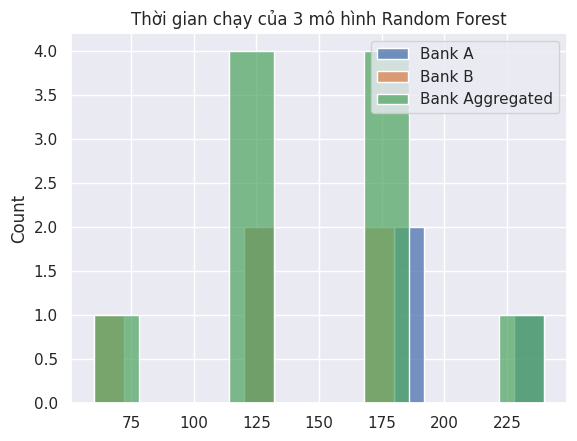

In [ ]:
# Đo thời gian chạy của thuật toán RF trên ngân hàng A, ngân hàng B và tổng hợp 2 ngân hàng
ax = sns.histplot(timeA_ID3, bins=10, label='Bank A', kde=False)
ax = sns.histplot(timeB_ID3, bins=10, label='Bank B', kde=False)
ax = sns.histplot(time_ID3, bins=10, label='Bank Aggregated', kde=False)
ax.legend()
ax.set_title('Thời gian chạy của 3 mô hình Random Forest')
plt.show()

### Độ chính xác

In [ ]:
# Tính toán độ chính xác của thuật toán RF trên ngân hàng A, ngân hàng B và tổng hợp 2 ngân hàng
accuracy_A = round(accuracy_score(y_test_A, y_pred_A) * 100, 3)
accuracy_B = round(accuracy_score(y_test_B, y_pred_B) * 100, 3)
accuracy_aggregated = round(accuracy_score(y_test, y_pred) * 100, 3)

print(accuracy_A, accuracy_B, accuracy_aggregated)

57.817 58.047 58.007


In [ ]:
# Tạo các nhãn cho cột
labels = ['Bank A', 'Bank B', 'Bank Aggregated']

# Tạo mảng giá trị độ chính xác
accuracy_values = np.array([accuracy_A, accuracy_B, accuracy_aggregated])

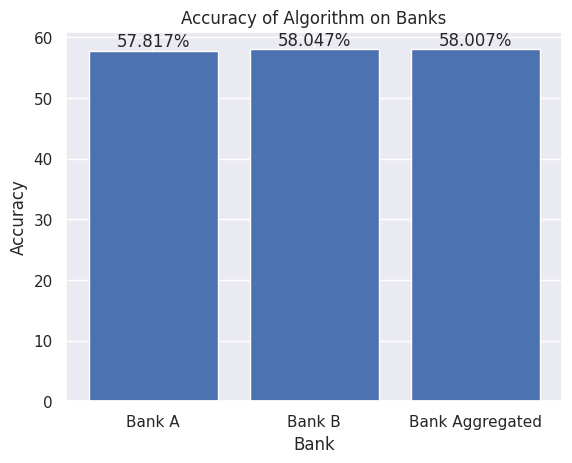

In [ ]:
# Vẽ biểu đồ cột
plt.bar(labels, accuracy_values)
plt.xlabel('Bank')
plt.ylabel('Accuracy')
plt.title('Accuracy of Algorithm on Banks')

# Gán nhãn cho từng cột
for i, v in enumerate(accuracy_values):
    plt.text(i, v, f'{v}%', ha='center', va='bottom')
    
plt.show()

### Dự báo

In [ ]:
y_pred_A

array([0, 0, 1, ..., 0, 1, 1])

In [ ]:
y_pred_B

array([0, 1, 1, ..., 0, 1, 0])

In [ ]:
y_pred

array([1, 1, 0, ..., 1, 0, 0])